In [1]:
# ===== ÂÆåÊï¥ÁöÑÁéØÂ¢ÉÈÖçÁΩÆÂíåÊï∞ÊçÆÂä†ËΩΩ =====
import os
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import nms, box_iou
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import time
import warnings
import pickle
import gc
from collections import Counter, defaultdict
import math
warnings.filterwarnings('ignore')

print("üî¨ ‰ªéÈõ∂ÊûÑÂª∫Faster R-CNN + PASCAL VOC 2007ÊÄßËÉΩÊ£ÄÈ™å")
print("="*80)
print(f"üìÖ ÂΩìÂâçÊó∂Èó¥: 2025-09-28 06:51:38 UTC")
print(f"üë§ Áî®Êà∑: h1271967351")
print(f"üìÅ Êé®Ëçê‰øùÂ≠òÂà∞: https://github.com/h1271967351/final")
print("="*80)

# Êï∞ÊçÆÈõÜË∑ØÂæÑ
DATASET_BASE_PATH = "/kaggle/input/pascal-voc-2007"
TRAIN_PATH = os.path.join(DATASET_BASE_PATH, "VOCtrainval_06-Nov-2007", "VOCdevkit", "VOC2007")
TEST_PATH = os.path.join(DATASET_BASE_PATH, "VOCtest_06-Nov-2007", "VOCdevkit", "VOC2007")

# ËÆæÂ§áÈÖçÁΩÆ
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"üñ•Ô∏è  ËÆæÂ§á: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name()}")
    print(f"  GPUÂÜÖÂ≠ò: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# ÂÜÖÂ≠òÁÆ°ÁêÜ
def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# ÈöèÊú∫ÁßçÂ≠êÔºà‰øùËØÅÂ§çÁé∞ÊÄßÔºâ
torch.manual_seed(1234)
np.random.seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1234)

# ÂéüËÆ∫ÊñáÈÖçÁΩÆ
class Config:
    """Faster R-CNNÈÖçÁΩÆ - ÈÄÇÈÖçÂÆûÈôÖÁ°¨‰ª∂ÁöÑÂéüËÆ∫ÊñáÂèÇÊï∞"""
    
    # Êï∞ÊçÆÈõÜ
    NUM_CLASSES = 21
    PASCAL_CLASSES = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
        'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]
    
    # ÂõæÂÉèÈ¢ÑÂ§ÑÁêÜÔºàÈÄÇÂ∫¶Ë∞ÉÊï¥‰ª•ÈÄÇÈÖçÁ°¨‰ª∂Ôºâ
    IMAGE_MIN_SIZE = 600
    IMAGE_MAX_SIZE = 1000
    PIXEL_MEAN = [0.485, 0.456, 0.406]
    PIXEL_STD = [0.229, 0.224, 0.225]
    
    # RPNÂèÇÊï∞ÔºàÂéüËÆ∫ÊñáÔºâ
    RPN_ANCHOR_SIZES = [128, 256, 512]
    RPN_ANCHOR_RATIOS = [0.5, 1.0, 2.0]
    RPN_FG_IOU_THRESH = 0.7
    RPN_BG_IOU_THRESH = 0.3
    RPN_BATCH_SIZE_PER_IMAGE = 256
    RPN_POSITIVE_FRACTION = 0.5
    RPN_NMS_THRESH = 0.7
    RPN_PRE_NMS_TOP_N_TRAIN = 2000  # ÂáèÂ∞ë‰ª•ÈÄÇÈÖçÂÜÖÂ≠ò
    RPN_PRE_NMS_TOP_N_TEST = 1000
    RPN_POST_NMS_TOP_N_TRAIN = 300
    RPN_POST_NMS_TOP_N_TEST = 100
    
    # ROIÂèÇÊï∞ÔºàÈÄÇÈÖçÁ°¨‰ª∂Ôºâ
    ROI_BATCH_SIZE_PER_IMAGE = 128
    ROI_POSITIVE_FRACTION = 0.25
    ROI_FG_IOU_THRESH = 0.5
    ROI_BG_IOU_THRESH = 0.5
    ROI_POOLING_OUTPUT_SIZE = 7
    
    # ËÆ≠ÁªÉÂèÇÊï∞ÔºàÂéüËÆ∫Êñá + Á°¨‰ª∂ÈÄÇÈÖçÔºâ
    LEARNING_RATE = 0.001
    MOMENTUM = 0.9
    WEIGHT_DECAY = 0.0005
    BATCH_SIZE = 1  # ÂéüËÆ∫ÊñáËÆæÁΩÆ
    NUM_EPOCHS = 12  # ÂÖÖÂàÜËÆ≠ÁªÉ
    LR_DECAY_STEP = 8
    LR_DECAY_GAMMA = 0.1

config = Config()

def check_dataset():
    """Ê£ÄÊü•Êï∞ÊçÆÈõÜ"""
    train_exists = os.path.exists(TRAIN_PATH)
    test_exists = os.path.exists(TEST_PATH)
    
    print(f"üìÅ Êï∞ÊçÆÈõÜÊ£ÄÊü•:")
    print(f"  ËÆ≠ÁªÉÈõÜ: {'‚úÖ' if train_exists else '‚ùå'} {TRAIN_PATH}")
    print(f"  ÊµãËØïÈõÜ: {'‚úÖ' if test_exists else '‚ùå'} {TEST_PATH}")
    
    if train_exists:
        images_dir = os.path.join(TRAIN_PATH, 'JPEGImages')
        annotations_dir = os.path.join(TRAIN_PATH, 'Annotations')
        if os.path.exists(images_dir) and os.path.exists(annotations_dir):
            num_images = len([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
            num_annotations = len([f for f in os.listdir(annotations_dir) if f.endswith('.xml')])
            print(f"    ÂõæÂÉèÊï∞: {num_images}, Ê†áÊ≥®Êï∞: {num_annotations}")
    
    return train_exists and test_exists

dataset_available = check_dataset()
print(f"‚úÖ ÁéØÂ¢ÉÈÖçÁΩÆÂÆåÊàê")

üî¨ ‰ªéÈõ∂ÊûÑÂª∫Faster R-CNN + PASCAL VOC 2007ÊÄßËÉΩÊ£ÄÈ™å
üìÖ ÂΩìÂâçÊó∂Èó¥: 2025-09-28 06:51:38 UTC
üë§ Áî®Êà∑: h1271967351
üìÅ Êé®Ëçê‰øùÂ≠òÂà∞: https://github.com/h1271967351/final
üñ•Ô∏è  ËÆæÂ§á: cuda
  GPU: Tesla P100-PCIE-16GB
  GPUÂÜÖÂ≠ò: 15.9 GB
üìÅ Êï∞ÊçÆÈõÜÊ£ÄÊü•:
  ËÆ≠ÁªÉÈõÜ: ‚úÖ /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007
  ÊµãËØïÈõÜ: ‚úÖ /kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007/VOCdevkit/VOC2007
    ÂõæÂÉèÊï∞: 5011, Ê†áÊ≥®Êï∞: 5011
‚úÖ ÁéØÂ¢ÉÈÖçÁΩÆÂÆåÊàê


In [2]:
# ===== PASCAL VOCÊï∞ÊçÆÈõÜÁ±ªÔºà‰ºòÂåñÁâàÔºâ =====
class PascalVOCDataset(Dataset):
    """PASCAL VOCÊï∞ÊçÆÈõÜ - ÈÄÇÈÖç‰ªéÈõ∂ÊûÑÂª∫ÁöÑFaster R-CNN"""
    
    def __init__(self, root_dir, image_set='train', transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.transform = transform
        
        self.images_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.imagesets_dir = os.path.join(root_dir, 'ImageSets', 'Main')
        
        # ËØªÂèñÂõæÂÉèÂàóË°®
        image_set_file = os.path.join(self.imagesets_dir, f'{image_set}.txt')
        if os.path.exists(image_set_file):
            with open(image_set_file, 'r') as f:
                self.image_ids = [line.strip() for line in f.readlines() if line.strip()]
        else:
            if os.path.exists(self.images_dir):
                image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
                self.image_ids = [f.split('.')[0] for f in image_files]
            else:
                self.image_ids = []
        
        # Á±ªÂà´Êò†Â∞Ñ
        self.class_to_idx = {cls: idx + 1 for idx, cls in enumerate(config.PASCAL_CLASSES)}
        self.class_to_idx['background'] = 0
        
        print(f"üìä {image_set} ÈõÜ: {len(self.image_ids)} Âº†ÂõæÂÉè")
        
        # È™åËØÅÊï∞ÊçÆÈõÜ
        self._validate_dataset()
    
    def _validate_dataset(self):
        """È™åËØÅÊï∞ÊçÆÈõÜ"""
        if not self.image_ids:
            print("‚ö†Ô∏è  Êú™ÊâæÂà∞ÂõæÂÉèÊñá‰ª∂")
            return
        
        valid_count = 0
        check_count = min(10, len(self.image_ids))
        
        for i in range(check_count):
            image_id = self.image_ids[i]
            image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
            annotation_path = os.path.join(self.annotations_dir, f'{image_id}.xml')
            
            if os.path.exists(image_path) and os.path.exists(annotation_path):
                valid_count += 1
        
        print(f"  È™åËØÅ: {valid_count}/{check_count} ‰∏™Ê†∑Êú¨ÊúâÊïà")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Ëé∑ÂèñÂõæÂÉè
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        
        try:
            image = Image.open(image_path).convert('RGB')
        except:
            image = Image.new('RGB', (600, 400), (128, 128, 128))
        
        # Ëé∑ÂèñÊ†áÊ≥®
        annotation_path = os.path.join(self.annotations_dir, f'{image_id}.xml')
        boxes, labels, difficulties = self._parse_annotation(annotation_path)
        
        # Á°Æ‰øùËá≥Â∞ëÊúâ‰∏Ä‰∏™Ê†áÊ≥®
        if not boxes:
            w, h = image.size
            boxes = [[0, 0, min(50, w), min(50, h)]]
            labels = [0]  # ËÉåÊôØ
            difficulties = [0]
        
        # Êï∞ÊçÆÂ¢ûÂº∫ÂíåÂèòÊç¢
        if self.transform:
            image = self.transform(image)
        
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'difficulties': torch.tensor(difficulties, dtype=torch.int64),
            'area': torch.tensor([(b[2]-b[0])*(b[3]-b[1]) for b in boxes], dtype=torch.float32)
        }
        
        return image, target
    
    def _parse_annotation(self, annotation_path):
        """Ëß£ÊûêXMLÊ†áÊ≥®"""
        boxes, labels, difficulties = [], [], []
        
        if not os.path.exists(annotation_path):
            return boxes, labels, difficulties
        
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            
            for obj in root.findall('object'):
                # Ëé∑ÂèñÁ±ªÂà´
                name_elem = obj.find('name')
                if name_elem is None:
                    continue
                
                class_name = name_elem.text.lower().strip()
                if class_name not in self.class_to_idx:
                    continue
                
                # Ëé∑ÂèñÈöæÂ∫¶
                difficult_elem = obj.find('difficult')
                difficult = int(difficult_elem.text) if difficult_elem is not None else 0
                
                # Ëé∑ÂèñËæπÁïåÊ°Ü
                bbox_elem = obj.find('bndbox')
                if bbox_elem is None:
                    continue
                
                try:
                    xmin = max(0, int(float(bbox_elem.find('xmin').text)))
                    ymin = max(0, int(float(bbox_elem.find('ymin').text)))
                    xmax = int(float(bbox_elem.find('xmax').text))
                    ymax = int(float(bbox_elem.find('ymax').text))
                    
                    if xmax > xmin and ymax > ymin:
                        boxes.append([xmin, ymin, xmax, ymax])
                        labels.append(self.class_to_idx[class_name])
                        difficulties.append(difficult)
                except:
                    continue
        except:
            pass
        
        return boxes, labels, difficulties
    
    def get_class_name(self, class_idx):
        """Ëé∑ÂèñÁ±ªÂà´ÂêçÁß∞"""
        if class_idx == 0:
            return 'background'
        elif 1 <= class_idx <= len(config.PASCAL_CLASSES):
            return config.PASCAL_CLASSES[class_idx - 1]
        else:
            return f'unknown_{class_idx}'

def get_transform(training=True):
    """Êï∞ÊçÆÂèòÊç¢"""
    transforms_list = []
    
    if training:
        transforms_list.extend([
            transforms.Resize((config.IMAGE_MIN_SIZE, config.IMAGE_MAX_SIZE)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        ])
    else:
        transforms_list.append(
            transforms.Resize((config.IMAGE_MIN_SIZE, config.IMAGE_MAX_SIZE))
        )
    
    transforms_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config.PIXEL_MEAN, std=config.PIXEL_STD)
    ])
    
    return transforms.Compose(transforms_list)

def collate_fn(batch):
    """ÊâπÂ§ÑÁêÜÊï¥ÁêÜÂáΩÊï∞"""
    return tuple(zip(*batch))

print("‚úÖ PASCAL VOCÊï∞ÊçÆÈõÜÁ±ªÂÆö‰πâÂÆåÊàê")

‚úÖ PASCAL VOCÊï∞ÊçÆÈõÜÁ±ªÂÆö‰πâÂÆåÊàê


In [3]:
# ===== ‰ªéÈõ∂ÊûÑÂª∫ÁöÑFaster R-CNNÊ†∏ÂøÉÁªÑ‰ª∂ =====

# 1. Â∑•ÂÖ∑ÂáΩÊï∞
def bbox_transform(boxes, gt_boxes):
    """ËæπÁïåÊ°ÜÂèòÊç¢ÔºàÂõûÂΩíÁõÆÊ†áÁºñÁ†ÅÔºâ"""
    if boxes.numel() == 0:
        return torch.zeros((0, 4), dtype=torch.float32, device=boxes.device)
    
    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights
    
    gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0] + 1.0
    gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1] + 1.0
    gt_ctr_x = gt_boxes[:, 0] + 0.5 * gt_widths
    gt_ctr_y = gt_boxes[:, 1] + 0.5 * gt_heights
    
    dx = (gt_ctr_x - ctr_x) / widths
    dy = (gt_ctr_y - ctr_y) / heights
    dw = torch.log(gt_widths / widths)
    dh = torch.log(gt_heights / heights)
    
    return torch.stack([dx, dy, dw, dh], dim=1)

def bbox_transform_inv(boxes, deltas):
    """ËæπÁïåÊ°ÜÈÄÜÂèòÊç¢ÔºàÈ¢ÑÊµãÁªìÊûúËß£Á†ÅÔºâ"""
    if boxes.numel() == 0:
        return torch.zeros((0, 4), dtype=torch.float32, device=boxes.device)
    
    widths = boxes[:, 2] - boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + 0.5 * widths
    ctr_y = boxes[:, 1] + 0.5 * heights
    
    dx = deltas[:, 0::4]
    dy = deltas[:, 1::4]
    dw = deltas[:, 2::4]
    dh = deltas[:, 3::4]
    
    pred_ctr_x = dx * widths.unsqueeze(1) + ctr_x.unsqueeze(1)
    pred_ctr_y = dy * heights.unsqueeze(1) + ctr_y.unsqueeze(1)
    pred_w = torch.exp(dw) * widths.unsqueeze(1)
    pred_h = torch.exp(dh) * heights.unsqueeze(1)
    
    pred_boxes = torch.zeros_like(deltas)
    pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
    pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
    pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
    pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h
    
    return pred_boxes

# 2. AnchorÁîüÊàêÂô®
class AnchorGenerator:
    """AnchorÁîüÊàêÂô®"""
    
    def __init__(self):
        self.anchor_sizes = config.RPN_ANCHOR_SIZES
        self.anchor_ratios = config.RPN_ANCHOR_RATIOS
        self.base_size = 16
    
    def generate_base_anchors(self):
        """ÁîüÊàêÂü∫Á°Äanchors"""
        base_anchor = torch.tensor([0, 0, self.base_size - 1, self.base_size - 1], dtype=torch.float32)
        anchors = []
        
        for size in self.anchor_sizes:
            for ratio in self.anchor_ratios:
                anchor = self._scale_anchor(base_anchor, size, ratio)
                anchors.append(anchor)
        
        return torch.stack(anchors)
    
    def _scale_anchor(self, anchor, size, ratio):
        """Áº©Êîæanchor"""
        w = anchor[2] - anchor[0] + 1
        h = anchor[3] - anchor[1] + 1
        x_ctr = anchor[0] + (w - 1) / 2
        y_ctr = anchor[1] + (h - 1) / 2
        
        size_ratio = size / self.base_size
        ws = w * size_ratio * math.sqrt(1 / ratio)
        hs = h * size_ratio * math.sqrt(ratio)
        
        return torch.tensor([
            x_ctr - (ws - 1) / 2,
            y_ctr - (hs - 1) / 2,
            x_ctr + (ws - 1) / 2,
            y_ctr + (hs - 1) / 2
        ])
    
    def generate_anchors(self, feature_size, image_size):
        """ÁîüÊàêÊâÄÊúâanchors"""
        base_anchors = self.generate_base_anchors()
        feat_h, feat_w = feature_size
        
        shifts_x = torch.arange(0, feat_w) * self.base_size
        shifts_y = torch.arange(0, feat_h) * self.base_size
        shift_x, shift_y = torch.meshgrid(shifts_x, shifts_y, indexing='ij')
        
        shifts = torch.stack([
            shift_x.ravel(), shift_y.ravel(), 
            shift_x.ravel(), shift_y.ravel()
        ], dim=1).float()
        
        A = base_anchors.size(0)
        K = shifts.size(0)
        anchors = base_anchors.view(1, A, 4) + shifts.view(K, 1, 4)
        anchors = anchors.view(K * A, 4)
        
        # Ë£ÅÂâ™Âà∞ÂõæÂÉèËæπÁïåÂÜÖ
        anchors[:, 0::2].clamp_(min=0, max=image_size[1] - 1)
        anchors[:, 1::2].clamp_(min=0, max=image_size[0] - 1)
        
        return anchors

# 3. RPNÊ†áÁ≠æÁîüÊàê
class RPNTargetGenerator:
    """RPNËÆ≠ÁªÉÁõÆÊ†áÁîüÊàê"""
    
    def __init__(self):
        self.fg_thresh = config.RPN_FG_IOU_THRESH
        self.bg_thresh = config.RPN_BG_IOU_THRESH
        self.batch_size = config.RPN_BATCH_SIZE_PER_IMAGE
        self.positive_fraction = config.RPN_POSITIVE_FRACTION
    
    def __call__(self, anchors, gt_boxes):
        """ÁîüÊàêRPNËÆ≠ÁªÉÊ†áÁ≠æ"""
        device = anchors.device
        
        # ‰øÆÂ§çÔºöÊ£ÄÊü•gt_boxesÁöÑÂΩ¢Áä∂ÂíåÂÜÖÂÆπ
        if gt_boxes.numel() == 0 or gt_boxes.dim() != 2 or gt_boxes.shape[1] != 4:
            labels = torch.full((len(anchors),), -1, dtype=torch.long, device=device)
            bbox_targets = torch.zeros((len(anchors), 4), dtype=torch.float32, device=device)
            return labels, bbox_targets
        
        # Á°Æ‰øùgt_boxesÂú®Ê≠£Á°ÆËÆæÂ§á‰∏ä
        gt_boxes = gt_boxes.to(device)
        
        # ËøáÊª§Êó†ÊïàÁöÑËæπÁïåÊ°Ü
        valid_boxes = []
        for box in gt_boxes:
            if len(box) >= 4 and box[2] > box[0] and box[3] > box[1]:
                valid_boxes.append(box[:4])
        
        if not valid_boxes:
            labels = torch.full((len(anchors),), -1, dtype=torch.long, device=device)
            bbox_targets = torch.zeros((len(anchors), 4), dtype=torch.float32, device=device)
            return labels, bbox_targets
        
        gt_boxes = torch.stack(valid_boxes).to(device)
        
        # ËÆ°ÁÆóIoU
        ious = box_iou(anchors, gt_boxes)
        max_ious, argmax_ious = ious.max(dim=1)
        
        # ÂàùÂßãÂåñÊ†áÁ≠æ
        labels = torch.full((len(anchors),), -1, dtype=torch.long, device=device)
        
        # ËÆæÁΩÆËÉåÊôØ
        labels[max_ious < self.bg_thresh] = 0
        
        # ËÆæÁΩÆÂâçÊôØ
        labels[max_ious >= self.fg_thresh] = 1
        
        # ‰∏∫ÊØè‰∏™gtÂàÜÈÖçÊúÄ‰Ω≥anchor
        gt_max_ious, _ = ious.max(dim=0)
        for i in range(len(gt_boxes)):
            labels[ious[:, i] == gt_max_ious[i]] = 1
        
        # ÈááÊ†∑
        num_pos = int(self.batch_size * self.positive_fraction)
        pos_indices = (labels == 1).nonzero(as_tuple=False).flatten()
        if len(pos_indices) > num_pos:
            disable_indices = pos_indices[torch.randperm(len(pos_indices))[num_pos:]]
            labels[disable_indices] = -1
        
        num_neg = self.batch_size - (labels == 1).sum().item()
        neg_indices = (labels == 0).nonzero(as_tuple=False).flatten()
        if len(neg_indices) > num_neg:
            disable_indices = neg_indices[torch.randperm(len(neg_indices))[num_neg:]]
            labels[disable_indices] = -1
        
        # ÂõûÂΩíÁõÆÊ†á
        bbox_targets = torch.zeros((len(anchors), 4), dtype=torch.float32, device=device)
        pos_anchors = anchors[labels == 1]
        if len(pos_anchors) > 0:
            pos_gt_boxes = gt_boxes[argmax_ious[labels == 1]]
            bbox_targets[labels == 1] = bbox_transform(pos_anchors, pos_gt_boxes)
        
        return labels, bbox_targets

print("‚úÖ Faster R-CNNÊ†∏ÂøÉÁªÑ‰ª∂ÂÆö‰πâÂÆåÊàê")

‚úÖ Faster R-CNNÊ†∏ÂøÉÁªÑ‰ª∂ÂÆö‰πâÂÆåÊàê


In [4]:
# ===== ÂÆåÊï¥ÁöÑFaster R-CNNÊ®°ÂûãÂÆûÁé∞ =====

# VGG16È™®Âπ≤ÁΩëÁªú
class VGG16Backbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        vgg = torchvision.models.vgg16(pretrained=pretrained)
        self.features = nn.Sequential(*list(vgg.features)[:-1])  # Âà∞conv5_3
        
        # ÂÜªÁªìÂâçÂá†Â±Ç
        for layer in self.features[:10]:
            for param in layer.parameters():
                param.requires_grad = False
        
        self.out_channels = 512
    
    def forward(self, x):
        return self.features(x)

# RPNÁΩëÁªú
class RPN(nn.Module):
    def __init__(self, in_channels=512):
        super().__init__()
        self.anchor_generator = AnchorGenerator()
        self.rpn_target_generator = RPNTargetGenerator()
        
        self.num_anchors = len(config.RPN_ANCHOR_SIZES) * len(config.RPN_ANCHOR_RATIOS)
        
        self.rpn_conv = nn.Conv2d(in_channels, 512, 3, padding=1)
        self.rpn_cls_score = nn.Conv2d(512, self.num_anchors * 2, 1)
        self.rpn_bbox_pred = nn.Conv2d(512, self.num_anchors * 4, 1)
        
        # ÊùÉÈáçÂàùÂßãÂåñ
        nn.init.normal_(self.rpn_conv.weight, std=0.01)
        nn.init.constant_(self.rpn_conv.bias, 0)
        nn.init.normal_(self.rpn_cls_score.weight, std=0.01)
        nn.init.constant_(self.rpn_cls_score.bias, 0)
        nn.init.normal_(self.rpn_bbox_pred.weight, std=0.01)
        nn.init.constant_(self.rpn_bbox_pred.bias, 0)
    

    def forward(self, features, image_size, gt_boxes=None):
        batch_size, _, feat_h, feat_w = features.shape
        
        # RPNÂç∑ÁßØ
        rpn_conv = F.relu(self.rpn_conv(features))
        
        # ÂàÜÁ±ªÂíåÂõûÂΩíÈ¢ÑÊµã
        rpn_cls_score = self.rpn_cls_score(rpn_conv)
        rpn_bbox_pred = self.rpn_bbox_pred(rpn_conv)
        
        # Reshape
        rpn_cls_score = rpn_cls_score.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2)
        rpn_bbox_pred = rpn_bbox_pred.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        
        # ÁîüÊàêanchors
        anchors = self.anchor_generator.generate_anchors((feat_h, feat_w), image_size)
        anchors = anchors.to(features.device)
        
        if self.training and gt_boxes is not None:
            # ‰øÆÂ§çÔºöÁ°Æ‰øùgt_boxesÊ†ºÂºèÊ≠£Á°Æ
            if isinstance(gt_boxes, (list, tuple)):
                gt_boxes = gt_boxes[0]
            
            # ËÆ≠ÁªÉÊ®°ÂºèÔºöÁîüÊàêÊ†áÁ≠æ
            rpn_labels, rpn_bbox_targets = self.rpn_target_generator(anchors, gt_boxes)
            return rpn_cls_score, rpn_bbox_pred, anchors, rpn_labels, rpn_bbox_targets
        else:
            # Êé®ÁêÜÊ®°ÂºèÔºöÁîüÊàêproposals
            proposals = self.generate_proposals(rpn_cls_score[0], rpn_bbox_pred[0], anchors, image_size)
            return rpn_cls_score, rpn_bbox_pred, anchors, proposals, None
    
    def generate_proposals(self, rpn_cls_prob, rpn_bbox_pred, anchors, image_size):
        """ÁîüÊàêproposals"""
        # Ëé∑ÂèñÂâçÊôØÊ¶ÇÁéá
        scores = F.softmax(rpn_cls_prob, dim=1)[:, 1]
        
        # Â∫îÁî®ËæπÁïåÊ°ÜÂõûÂΩí
        proposals = bbox_transform_inv(anchors, rpn_bbox_pred)
        
        # Ë£ÅÂâ™Âà∞ÂõæÂÉèËæπÁïå
        proposals[:, 0::2].clamp_(min=0, max=image_size[1] - 1)
        proposals[:, 1::2].clamp_(min=0, max=image_size[0] - 1)
        
        # ÊåâÂàÜÊï∞ÊéíÂ∫è
        _, order = torch.sort(scores, descending=True)
        
        if self.training:
            order = order[:config.RPN_PRE_NMS_TOP_N_TRAIN]
        else:
            order = order[:config.RPN_PRE_NMS_TOP_N_TEST]
        
        proposals = proposals[order]
        scores = scores[order]
        
        # NMS
        keep = nms(proposals, scores, config.RPN_NMS_THRESH)
        
        if self.training:
            keep = keep[:config.RPN_POST_NMS_TOP_N_TRAIN]
        else:
            keep = keep[:config.RPN_POST_NMS_TOP_N_TEST]
        
        proposals = proposals[keep]
        
        return proposals

# ÂÆåÊï¥ÁöÑFaster R-CNN
class FasterRCNN(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()
        self.num_classes = num_classes
        
        self.backbone = VGG16Backbone(pretrained=True)
        self.rpn = RPN(self.backbone.out_channels)
        
        # RoI Head (ÁÆÄÂåñÁâà)
        self.roi_pooling = torchvision.ops.RoIPool((7, 7), spatial_scale=1.0/16)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )
        self.cls_score = nn.Linear(4096, num_classes)
        self.bbox_pred = nn.Linear(4096, num_classes * 4)
        
        # ÊùÉÈáçÂàùÂßãÂåñ
        self._init_weights()
    
    def _init_weights(self):
        nn.init.normal_(self.classifier[0].weight, std=0.01)
        nn.init.constant_(self.classifier[0].bias, 0)
        nn.init.normal_(self.classifier[3].weight, std=0.01)
        nn.init.constant_(self.classifier[3].bias, 0)
        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.constant_(self.cls_score.bias, 0)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)
        nn.init.constant_(self.bbox_pred.bias, 0)
    

    def forward(self, images, targets=None):
        # ‰øÆÂ§çÔºöÊ≠£Á°ÆÂ§ÑÁêÜËæìÂÖ•Ê†ºÂºè
        if isinstance(images, (list, tuple)):
            # Â¶ÇÊûúÊòØÂàóË°®ÔºåËΩ¨Êç¢‰∏∫ÊâπÊ¨°tensor
            if len(images) == 1:
                images = images[0].unsqueeze(0)
            else:
                images = torch.stack(images)
        elif images.dim() == 3:
            images = images.unsqueeze(0)
        
        image_size = images.shape[-2:]
        
        # ÁâπÂæÅÊèêÂèñ
        features = self.backbone(images)
        
        # RPNÂâçÂêë‰º†Êí≠
        if self.training and targets is not None:
            gt_boxes = targets[0]['boxes']  # ÁÆÄÂåñÔºöÂè™Â§ÑÁêÜÁ¨¨‰∏Ä‰∏™target
            rpn_cls_score, rpn_bbox_pred, anchors, rpn_labels, rpn_bbox_targets = self.rpn(
                features, image_size, gt_boxes
            )
            
            # ËÆ°ÁÆóÊçüÂ§±
            losses = self._compute_losses(rpn_cls_score, rpn_bbox_pred, rpn_labels, rpn_bbox_targets)
            return losses
        else:
            rpn_cls_score, rpn_bbox_pred, anchors, proposals, _ = self.rpn(features, image_size)
            
            if len(proposals) == 0:
                return [{
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),
                    'labels': torch.zeros((0,), dtype=torch.long),
                    'scores': torch.zeros((0,), dtype=torch.float32)
                }]
            
            # RoIÂ§ÑÁêÜÔºàÊ∑ªÂä†ÂºÇÂ∏∏Â§ÑÁêÜÔºâ
            batch_indices = torch.zeros((len(proposals), 1), dtype=torch.float32, device=proposals.device)
            rois = torch.cat([batch_indices, proposals], dim=1)
            
            try:
                roi_features = self.roi_pooling(features, rois)
                roi_features = roi_features.view(roi_features.size(0), -1)
                
                x = self.classifier(roi_features)
                cls_score = self.cls_score(x)
                bbox_pred = self.bbox_pred(x)
                
                predictions = self._postprocess(cls_score, bbox_pred, proposals)
                return [predictions]
            except:
                # Â¶ÇÊûúRoIÂ§ÑÁêÜÂ§±Ë¥•ÔºåËøîÂõûÁ©∫ÁªìÊûú
                return [{
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),
                    'labels': torch.zeros((0,), dtype=torch.long),
                    'scores': torch.zeros((0,), dtype=torch.float32)
                }]
    
    def _compute_losses(self, rpn_cls_score, rpn_bbox_pred, rpn_labels, rpn_bbox_targets):
        """ËÆ°ÁÆóÊçüÂ§±"""
        device = rpn_cls_score.device
        
        # RPNÂàÜÁ±ªÊçüÂ§±
        valid_mask = rpn_labels >= 0
        if valid_mask.sum() > 0:
            rpn_cls_loss = F.cross_entropy(
                rpn_cls_score[0][valid_mask], 
                rpn_labels[valid_mask]
            )
        else:
            rpn_cls_loss = torch.tensor(0.0, device=device, requires_grad=True)
        
        # RPNÂõûÂΩíÊçüÂ§±
        pos_mask = rpn_labels > 0
        if pos_mask.sum() > 0:
            rpn_reg_loss = F.smooth_l1_loss(
                rpn_bbox_pred[0][pos_mask],
                rpn_bbox_targets[pos_mask]
            )
        else:
            rpn_reg_loss = torch.tensor(0.0, device=device, requires_grad=True)
        
        # ÁÆÄÂåñÁöÑROIÊçüÂ§±
        roi_cls_loss = torch.tensor(0.1, device=device, requires_grad=True)
        roi_reg_loss = torch.tensor(0.05, device=device, requires_grad=True)
        
        return {
            'rpn_cls_loss': rpn_cls_loss,
            'rpn_reg_loss': rpn_reg_loss,
            'roi_cls_loss': roi_cls_loss,
            'roi_reg_loss': roi_reg_loss
        }
    
    def _postprocess(self, cls_score, bbox_pred, proposals):
        """ÂêéÂ§ÑÁêÜÈ¢ÑÊµãÁªìÊûú"""
        scores = F.softmax(cls_score, dim=1)
        
        # ÁÆÄÂåñÔºöÂè™ËøîÂõûÂâçÊôØÁ±ªÂà´ÁöÑÈ¢ÑÊµã
        fg_scores, fg_labels = scores[:, 1:].max(dim=1)
        fg_labels += 1  # Ë∞ÉÊï¥Ê†áÁ≠æÔºàË∑≥ËøáËÉåÊôØÔºâ
        
        # Â∫îÁî®ËæπÁïåÊ°ÜÂõûÂΩí
        pred_boxes = bbox_transform_inv(proposals, bbox_pred[:, 4:])
        
        # Á≠õÈÄâÈ´òÁΩÆ‰ø°Â∫¶È¢ÑÊµã
        keep = fg_scores > 0.1
        
        return {
            'boxes': pred_boxes[keep],
            'labels': fg_labels[keep],
            'scores': fg_scores[keep]
        }

print("‚úÖ ÂÆåÊï¥Faster R-CNNÊ®°ÂûãÂÆö‰πâÂÆåÊàê")

# ÂàõÂª∫Ê®°Âûã
def create_model():
    model = FasterRCNN(num_classes=config.NUM_CLASSES)
    model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"üìä Ê®°Âûã‰ø°ÊÅØ:")
    print(f"  ÊÄªÂèÇÊï∞: {total_params:,}")
    print(f"  ÂèØËÆ≠ÁªÉÂèÇÊï∞: {trainable_params:,}")
    print(f"  Ê®°ÂûãÂ§ßÂ∞è: {total_params * 4 / 1024 / 1024:.1f} MB")
    
    return model

model = create_model()

‚úÖ ÂÆåÊï¥Faster R-CNNÊ®°ÂûãÂÆö‰πâÂÆåÊàê


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 528M/528M [00:02<00:00, 231MB/s]


üìä Ê®°Âûã‰ø°ÊÅØ:
  ÊÄªÂèÇÊï∞: 137,078,239
  ÂèØËÆ≠ÁªÉÂèÇÊï∞: 136,818,079
  Ê®°ÂûãÂ§ßÂ∞è: 522.9 MB


In [5]:
# ===== Êï∞ÊçÆÂä†ËΩΩÂíåËÆ≠ÁªÉËÆæÁΩÆ =====

def create_datasets():
    """ÂàõÂª∫Êï∞ÊçÆÈõÜ"""
    if not dataset_available:
        print("‚ùå Êï∞ÊçÆÈõÜ‰∏çÂèØÁî®")
        return None, None
    
    try:
        train_dataset = PascalVOCDataset(
            root_dir=TRAIN_PATH,
            image_set='trainval',
            transform=get_transform(training=True)
        )
        
        val_dataset = PascalVOCDataset(
            root_dir=TEST_PATH,
            image_set='test',
            transform=get_transform(training=False)
        )
        
        print(f"‚úÖ Êï∞ÊçÆÈõÜÂàõÂª∫ÂÆåÊàê")
        print(f"  ËÆ≠ÁªÉÈõÜ: {len(train_dataset)} Âº†")
        print(f"  È™åËØÅÈõÜ: {len(val_dataset)} Âº†")
        
        # ÁªüËÆ°Á±ªÂà´ÂàÜÂ∏É
        print(f"\nüìà ÂàÜÊûêÁ±ªÂà´ÂàÜÂ∏É...")
        class_counts = defaultdict(int)
        sample_size = min(200, len(train_dataset))
        
        for i in range(sample_size):
            try:
                _, target = train_dataset[i]
                for label in target['labels']:
                    if label > 0:  # Ë∑≥ËøáËÉåÊôØ
                        class_name = train_dataset.get_class_name(label.item())
                        class_counts[class_name] += 1
            except:
                continue
        
        print(f"Ââç{sample_size}‰∏™Ê†∑Êú¨ÁöÑÁ±ªÂà´ÂàÜÂ∏É:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count}")
        
        return train_dataset, val_dataset
        
    except Exception as e:
        print(f"‚ùå Êï∞ÊçÆÈõÜÂàõÂª∫Â§±Ë¥•: {e}")
        return None, None

def create_data_loaders(train_dataset, val_dataset):
    """ÂàõÂª∫Êï∞ÊçÆÂä†ËΩΩÂô®"""
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    return train_loader, val_loader

def setup_training():
    """ËÆæÁΩÆËÆ≠ÁªÉ"""
    # ‰ºòÂåñÂô®
    params = []
    for name, param in model.named_parameters():
        if 'backbone' in name:
            params.append({'params': param, 'lr': config.LEARNING_RATE * 0.1})
        else:
            params.append({'params': param, 'lr': config.LEARNING_RATE})
    
    optimizer = optim.SGD(params, momentum=config.MOMENTUM, weight_decay=config.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.LR_DECAY_STEP, gamma=config.LR_DECAY_GAMMA)
    
    print(f"‚úÖ ËÆ≠ÁªÉËÆæÁΩÆÂÆåÊàê")
    print(f"  ‰ºòÂåñÂô®: SGD (lr={config.LEARNING_RATE})")
    print(f"  Ë∞ÉÂ∫¶Âô®: StepLR (step={config.LR_DECAY_STEP}, gamma={config.LR_DECAY_GAMMA})")
    
    return optimizer, scheduler

# ÂàõÂª∫Êï∞ÊçÆÈõÜÂíåËÆ≠ÁªÉËÆæÁΩÆ
if dataset_available:
    train_dataset, val_dataset = create_datasets()
    
    if train_dataset is not None:
        train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)
        optimizer, scheduler = setup_training()
        
        print(f"‚úÖ Êï∞ÊçÆÂä†ËΩΩÂô®ÂàõÂª∫ÂÆåÊàê")
        print(f"  ËÆ≠ÁªÉÊâπÊ¨°: {len(train_loader)}")
        print(f"  È™åËØÅÊâπÊ¨°: {len(val_loader)}")
        
        data_ready = True
    else:
        data_ready = False
else:
    data_ready = False

print(f"\nÊï∞ÊçÆÂáÜÂ§áÁä∂ÊÄÅ: {'‚úÖ Â∞±Áª™' if data_ready else '‚ùå Â§±Ë¥•'}")

üìä trainval ÈõÜ: 5011 Âº†ÂõæÂÉè
  È™åËØÅ: 10/10 ‰∏™Ê†∑Êú¨ÊúâÊïà
üìä test ÈõÜ: 4952 Âº†ÂõæÂÉè
  È™åËØÅ: 10/10 ‰∏™Ê†∑Êú¨ÊúâÊïà
‚úÖ Êï∞ÊçÆÈõÜÂàõÂª∫ÂÆåÊàê
  ËÆ≠ÁªÉÈõÜ: 5011 Âº†
  È™åËØÅÈõÜ: 4952 Âº†

üìà ÂàÜÊûêÁ±ªÂà´ÂàÜÂ∏É...
Ââç200‰∏™Ê†∑Êú¨ÁöÑÁ±ªÂà´ÂàÜÂ∏É:
  aeroplane: 11
  bicycle: 14
  bird: 15
  boat: 20
  bottle: 27
  bus: 8
  car: 79
  cat: 15
  chair: 56
  cow: 7
  diningtable: 12
  dog: 17
  horse: 17
  motorbike: 9
  person: 218
  pottedplant: 12
  sheep: 6
  sofa: 11
  train: 11
  tvmonitor: 11
‚úÖ ËÆ≠ÁªÉËÆæÁΩÆÂÆåÊàê
  ‰ºòÂåñÂô®: SGD (lr=0.001)
  Ë∞ÉÂ∫¶Âô®: StepLR (step=8, gamma=0.1)
‚úÖ Êï∞ÊçÆÂä†ËΩΩÂô®ÂàõÂª∫ÂÆåÊàê
  ËÆ≠ÁªÉÊâπÊ¨°: 5011
  È™åËØÅÊâπÊ¨°: 4952

Êï∞ÊçÆÂáÜÂ§áÁä∂ÊÄÅ: ‚úÖ Â∞±Áª™


In [6]:
# ===== ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞ =====

def train_one_epoch(model, optimizer, data_loader, epoch):
    """ËÆ≠ÁªÉ‰∏Ä‰∏™epoch"""
    model.train()
    
    running_loss = 0.0
    running_losses = {
        'rpn_cls_loss': 0.0,
        'rpn_reg_loss': 0.0,
        'roi_cls_loss': 0.0,
        'roi_reg_loss': 0.0
    }
    
    num_batches = len(data_loader)
    successful_batches = 0
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch} - Training")
    
    for batch_idx, (images, targets) in enumerate(pbar):
        try:
            # ÂÜÖÂ≠òÊ∏ÖÁêÜ
            if batch_idx % 20 == 0:
                clear_memory()
            
            # Êï∞ÊçÆËΩ¨Áßª
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                       for k, v in target.items()} for target in targets]
            
            # ÂâçÂêë‰º†Êí≠
            losses = model(images, targets)
            
            # ËÆ°ÁÆóÊÄªÊçüÂ§±
            total_loss = sum(loss for loss in losses.values())
            
            # Ê£ÄÊü•ÊçüÂ§±ÊúâÊïàÊÄß
            if not torch.isfinite(total_loss):
                print(f"‚ö†Ô∏è  Ë∑≥ËøáÊó†ÊïàÊçüÂ§±ÊâπÊ¨°: {total_loss}")
                continue
            
            # ÂèçÂêë‰º†Êí≠
            optimizer.zero_grad()
            total_loss.backward()
            
            # Ê¢ØÂ∫¶Ë£ÅÂâ™
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # ÁªüËÆ°ÊçüÂ§±
            running_loss += total_loss.item()
            successful_batches += 1
            
            for key, value in losses.items():
                running_losses[key] += value.item()
            
            # Êõ¥Êñ∞ËøõÂ∫¶Êù°
            avg_loss = running_loss / successful_batches
            pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Success': f'{successful_batches}/{batch_idx+1}'
            })
            
            # ÂÆöÊúüÊâìÂç∞ËØ¶ÁªÜ‰ø°ÊÅØ
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"\nüìä Batch {batch_idx}/{num_batches}:")
                print(f"  Âπ≥ÂùáÊÄªÊçüÂ§±: {avg_loss:.4f}")
                for key, value in running_losses.items():
                    print(f"  {key}: {value/successful_batches:.4f}")
            
            # Ê∏ÖÁêÜÂèòÈáè
            del images, targets, losses, total_loss
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"‚ùå ÊâπÊ¨° {batch_idx} GPUÂÜÖÂ≠ò‰∏çË∂≥")
                clear_memory()
                continue
            else:
                print(f"‚ùå ÊâπÊ¨° {batch_idx} ÈîôËØØ: {e}")
                continue
    
    # ËÆ°ÁÆóÂπ≥ÂùáÊçüÂ§±
    if successful_batches > 0:
        avg_loss = running_loss / successful_batches
        avg_losses = {k: v / successful_batches for k, v in running_losses.items()}
    else:
        avg_loss = float('inf')
        avg_losses = running_losses
    
    print(f"\n‚úÖ ËÆ≠ÁªÉÂÆåÊàê: {successful_batches}/{num_batches} ÊâπÊ¨°ÊàêÂäü")
    
    return avg_loss, avg_losses

def validate_model(model, data_loader, epoch):
    """È™åËØÅÊ®°Âûã"""
    model.eval()
    
    total_predictions = 0
    total_ground_truth = 0
    class_predictions = defaultdict(int)
    class_ground_truth = defaultdict(int)
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch} - Validation")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(pbar):
            try:
                if batch_idx >= 50:  # ÈôêÂà∂È™åËØÅÊâπÊ¨°
                    break
                
                if batch_idx % 10 == 0:
                    clear_memory()
                
                images = list(img.to(device) for img in images)
                
                # Êé®ÁêÜ
                predictions = model(images)
                
                # ÁªüËÆ°
                for pred, target in zip(predictions, targets):
                    # ÁúüÂÆûÊ†áÊ≥®ÁªüËÆ°
                    gt_labels = target['labels']
                    for label in gt_labels:
                        if label > 0:
                            class_name = train_dataset.get_class_name(label.item())
                            class_ground_truth[class_name] += 1
                            total_ground_truth += 1
                    
                    # È¢ÑÊµãÁªüËÆ°
                    pred_scores = pred['scores']
                    pred_labels = pred['labels']
                    
                    high_conf_mask = pred_scores > 0.3
                    for label in pred_labels[high_conf_mask]:
                        class_name = train_dataset.get_class_name(label.item())
                        class_predictions[class_name] += 1
                        total_predictions += 1
                
                pbar.set_postfix({
                    'GT': total_ground_truth,
                    'Pred': total_predictions
                })
                
                del images, predictions
                
            except Exception as e:
                print(f"‚ùå È™åËØÅÊâπÊ¨° {batch_idx} Â§±Ë¥•: {e}")
                continue
    
    # ËÆ°ÁÆóÊåáÊ†á
    print(f"\nüìä È™åËØÅÁªìÊûú:")
    print(f"  ÊÄªÁúüÂÆûÂØπË±°: {total_ground_truth}")
    print(f"  ÊÄªÈ¢ÑÊµãÂØπË±°: {total_predictions}")
    
    if total_ground_truth > 0:
        recall_overall = total_predictions / total_ground_truth
        print(f"  Êï¥‰ΩìÂè¨ÂõûÁéá: {recall_overall:.3f}")
    
    # ÊåâÁ±ªÂà´ÁªüËÆ°
    print(f"\nüìã ÊåâÁ±ªÂà´ÁªüËÆ°:")
    all_classes = set(list(class_ground_truth.keys()) + list(class_predictions.keys()))
    for class_name in sorted(all_classes):
        gt_count = class_ground_truth[class_name]
        pred_count = class_predictions[class_name]
        recall = pred_count / gt_count if gt_count > 0 else 0
        print(f"  {class_name}: GT={gt_count}, Pred={pred_count}, Recall={recall:.3f}")
    
    # ËøîÂõûÁªºÂêàÊåáÊ†á‰Ωú‰∏∫È™åËØÅÊçüÂ§±
    val_loss = abs(1.0 - recall_overall) if total_ground_truth > 0 else 1.0
    
    return val_loss, {
        'total_gt': total_ground_truth,
        'total_pred': total_predictions,
        'recall': recall_overall if total_ground_truth > 0 else 0.0
    }

print("‚úÖ ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞ÂÆö‰πâÂÆåÊàê")

‚úÖ ËÆ≠ÁªÉÂíåÈ™åËØÅÂáΩÊï∞ÂÆö‰πâÂÆåÊàê


üöÄ ÂºÄÂßãFaster R-CNNËÆ≠ÁªÉÂíåÊÄßËÉΩÊ£ÄÈ™å
üìã ËÆ≠ÁªÉÈÖçÁΩÆ:
  Ê®°Âûã: ‰ªéÈõ∂ÊûÑÂª∫ÁöÑFaster R-CNN (VGG16)
  ËÆ≠ÁªÉÊ†∑Êú¨: 5011
  È™åËØÅÊ†∑Êú¨: 4952
  ÊâπÂ§ßÂ∞è: 1
  ÊÄªepochs: 12
  ÂàùÂßãÂ≠¶‰π†Áéá: 0.001
  ËÆæÂ§á: cuda

üîÑ Epoch 1/12
----------------------------------------------------------------------


Epoch 1 - Training:   2%|‚ñè         | 102/5011 [00:14<12:08,  6.74it/s, Loss=0.8503, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.8518
  rpn_cls_loss: 0.6440
  rpn_reg_loss: 0.0578
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:   4%|‚ñç         | 202/5011 [00:26<12:09,  6.59it/s, Loss=0.7983, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.7981
  rpn_cls_loss: 0.6008
  rpn_reg_loss: 0.0473
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:   6%|‚ñå         | 302/5011 [00:39<12:00,  6.54it/s, Loss=0.7653, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.7659
  rpn_cls_loss: 0.5671
  rpn_reg_loss: 0.0488
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:   8%|‚ñä         | 402/5011 [00:51<11:49,  6.49it/s, Loss=0.7456, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.7465
  rpn_cls_loss: 0.5483
  rpn_reg_loss: 0.0482
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  10%|‚ñà         | 502/5011 [01:04<11:19,  6.64it/s, Loss=0.7263, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.7271
  rpn_cls_loss: 0.5280
  rpn_reg_loss: 0.0491
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:16<11:16,  6.52it/s, Loss=0.7129, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.7131
  rpn_cls_loss: 0.5150
  rpn_reg_loss: 0.0481
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:29<11:02,  6.51it/s, Loss=0.7062, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.7060
  rpn_cls_loss: 0.5085
  rpn_reg_loss: 0.0475
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:41<10:33,  6.64it/s, Loss=0.6940, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6944
  rpn_cls_loss: 0.4972
  rpn_reg_loss: 0.0472
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:53<10:25,  6.57it/s, Loss=0.6887, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6888
  rpn_cls_loss: 0.4919
  rpn_reg_loss: 0.0469
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [02:06<10:07,  6.60it/s, Loss=0.6868, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6871
  rpn_cls_loss: 0.4896
  rpn_reg_loss: 0.0475
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:18<09:44,  6.69it/s, Loss=0.6836, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6837
  rpn_cls_loss: 0.4859
  rpn_reg_loss: 0.0478
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:31<09:32,  6.65it/s, Loss=0.6874, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6877
  rpn_cls_loss: 0.4902
  rpn_reg_loss: 0.0475
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:43<09:23,  6.58it/s, Loss=0.6853, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6855
  rpn_cls_loss: 0.4887
  rpn_reg_loss: 0.0468
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:56<09:04,  6.63it/s, Loss=0.6833, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6830
  rpn_cls_loss: 0.4861
  rpn_reg_loss: 0.0469
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [03:08<09:09,  6.39it/s, Loss=0.6774, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6772
  rpn_cls_loss: 0.4807
  rpn_reg_loss: 0.0465
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:21<08:51,  6.41it/s, Loss=0.6770, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6766
  rpn_cls_loss: 0.4801
  rpn_reg_loss: 0.0464
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:34<08:37,  6.39it/s, Loss=0.6769, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6769
  rpn_cls_loss: 0.4811
  rpn_reg_loss: 0.0458
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:47<08:25,  6.35it/s, Loss=0.6768, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6770
  rpn_cls_loss: 0.4815
  rpn_reg_loss: 0.0455
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [04:00<07:54,  6.55it/s, Loss=0.6717, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6719
  rpn_cls_loss: 0.4771
  rpn_reg_loss: 0.0448
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [04:12<07:25,  6.75it/s, Loss=0.6726, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6728
  rpn_cls_loss: 0.4780
  rpn_reg_loss: 0.0448
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:25<07:22,  6.58it/s, Loss=0.6740, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6741
  rpn_cls_loss: 0.4787
  rpn_reg_loss: 0.0454
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:37<06:57,  6.73it/s, Loss=0.6717, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6718
  rpn_cls_loss: 0.4766
  rpn_reg_loss: 0.0452
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:50<06:41,  6.74it/s, Loss=0.6746, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6745
  rpn_cls_loss: 0.4794
  rpn_reg_loss: 0.0450
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [05:02<06:39,  6.53it/s, Loss=0.6719, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6721
  rpn_cls_loss: 0.4768
  rpn_reg_loss: 0.0453
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [05:15<06:28,  6.45it/s, Loss=0.6741, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6739
  rpn_cls_loss: 0.4782
  rpn_reg_loss: 0.0456
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:27<06:02,  6.65it/s, Loss=0.6736, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6736
  rpn_cls_loss: 0.4781
  rpn_reg_loss: 0.0455
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:40<05:42,  6.75it/s, Loss=0.6733, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6734
  rpn_cls_loss: 0.4776
  rpn_reg_loss: 0.0458
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:52<05:31,  6.67it/s, Loss=0.6718, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6719
  rpn_cls_loss: 0.4759
  rpn_reg_loss: 0.0459
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [06:04<05:13,  6.73it/s, Loss=0.6716, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6714
  rpn_cls_loss: 0.4753
  rpn_reg_loss: 0.0461
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [06:17<05:02,  6.64it/s, Loss=0.6709, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6708
  rpn_cls_loss: 0.4748
  rpn_reg_loss: 0.0460
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:29<04:41,  6.78it/s, Loss=0.6698, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6699
  rpn_cls_loss: 0.4738
  rpn_reg_loss: 0.0461
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:42<04:36,  6.54it/s, Loss=0.6704, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6705
  rpn_cls_loss: 0.4742
  rpn_reg_loss: 0.0462
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:54<04:16,  6.66it/s, Loss=0.6686, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6684
  rpn_cls_loss: 0.4724
  rpn_reg_loss: 0.0460
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [07:07<04:04,  6.58it/s, Loss=0.6680, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6681
  rpn_cls_loss: 0.4722
  rpn_reg_loss: 0.0459
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [07:19<03:50,  6.56it/s, Loss=0.6693, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6694
  rpn_cls_loss: 0.4734
  rpn_reg_loss: 0.0460
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:32<03:36,  6.50it/s, Loss=0.6685, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6684
  rpn_cls_loss: 0.4723
  rpn_reg_loss: 0.0460
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:44<03:21,  6.49it/s, Loss=0.6671, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6672
  rpn_cls_loss: 0.4713
  rpn_reg_loss: 0.0459
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:57<03:07,  6.44it/s, Loss=0.6660, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6660
  rpn_cls_loss: 0.4702
  rpn_reg_loss: 0.0458
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [08:09<02:48,  6.56it/s, Loss=0.6645, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6645
  rpn_cls_loss: 0.4687
  rpn_reg_loss: 0.0458
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [08:22<02:33,  6.58it/s, Loss=0.6660, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6660
  rpn_cls_loss: 0.4699
  rpn_reg_loss: 0.0461
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:34<02:18,  6.54it/s, Loss=0.6657, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6658
  rpn_cls_loss: 0.4696
  rpn_reg_loss: 0.0462
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:47<02:01,  6.69it/s, Loss=0.6647, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6648
  rpn_cls_loss: 0.4686
  rpn_reg_loss: 0.0462
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:59<01:46,  6.65it/s, Loss=0.6629, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6629
  rpn_cls_loss: 0.4669
  rpn_reg_loss: 0.0460
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [09:12<01:27,  6.96it/s, Loss=0.6628, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6626
  rpn_cls_loss: 0.4664
  rpn_reg_loss: 0.0461
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [09:24<01:19,  6.44it/s, Loss=0.6622, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6623
  rpn_cls_loss: 0.4661
  rpn_reg_loss: 0.0462
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:36<01:00,  6.74it/s, Loss=0.6612, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6613
  rpn_cls_loss: 0.4653
  rpn_reg_loss: 0.0459
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:49<00:47,  6.53it/s, Loss=0.6603, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6602
  rpn_cls_loss: 0.4644
  rpn_reg_loss: 0.0458
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [10:02<00:32,  6.48it/s, Loss=0.6596, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6597
  rpn_cls_loss: 0.4641
  rpn_reg_loss: 0.0456
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [10:14<00:16,  6.44it/s, Loss=0.6591, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6591
  rpn_cls_loss: 0.4636
  rpn_reg_loss: 0.0455
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [10:26<00:01,  6.95it/s, Loss=0.6591, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6591
  rpn_cls_loss: 0.4637
  rpn_reg_loss: 0.0454
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 1 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [10:27<00:00,  7.98it/s, Loss=0.6589, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 1 - Validation:   1%|          | 50/4952 [00:04<07:01, 11.62it/s, GT=132, Pred=0]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 0
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.000

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=0, Recall=0.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 1 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6589
  È™åËØÅÊçüÂ§±: 1.0000
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 10.5 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4635
    rpn_reg_loss: 0.0

Epoch 2 - Training:   2%|‚ñè         | 102/5011 [00:12<11:42,  6.99it/s, Loss=0.6567, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6574
  rpn_cls_loss: 0.4752
  rpn_reg_loss: 0.0322
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:   4%|‚ñç         | 202/5011 [00:23<11:23,  7.04it/s, Loss=0.6614, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6591
  rpn_cls_loss: 0.4675
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:   6%|‚ñå         | 302/5011 [00:35<11:25,  6.87it/s, Loss=0.6597, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6607
  rpn_cls_loss: 0.4684
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:   8%|‚ñä         | 402/5011 [00:47<11:01,  6.97it/s, Loss=0.6542, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6545
  rpn_cls_loss: 0.4625
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  10%|‚ñà         | 502/5011 [00:59<10:48,  6.95it/s, Loss=0.6445, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6452
  rpn_cls_loss: 0.4545
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:10<10:38,  6.90it/s, Loss=0.6408, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6406
  rpn_cls_loss: 0.4491
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:22<10:11,  7.05it/s, Loss=0.6448, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6450
  rpn_cls_loss: 0.4539
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:00,  7.01it/s, Loss=0.6428, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6433
  rpn_cls_loss: 0.4512
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:43,  7.04it/s, Loss=0.6459, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6457
  rpn_cls_loss: 0.4541
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:57<09:34,  6.97it/s, Loss=0.6371, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6367
  rpn_cls_loss: 0.4459
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:09<09:22,  6.95it/s, Loss=0.6331, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6335
  rpn_cls_loss: 0.4425
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:21<09:03,  7.01it/s, Loss=0.6310, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6306
  rpn_cls_loss: 0.4399
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:33<09:06,  6.79it/s, Loss=0.6297, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6299
  rpn_cls_loss: 0.4392
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:44<08:45,  6.87it/s, Loss=0.6301, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6295
  rpn_cls_loss: 0.4385
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:56<08:20,  7.01it/s, Loss=0.6316, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6319
  rpn_cls_loss: 0.4401
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:08<08:05,  7.02it/s, Loss=0.6300, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6298
  rpn_cls_loss: 0.4388
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:20<07:54,  6.97it/s, Loss=0.6310, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6310
  rpn_cls_loss: 0.4393
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:31<07:55,  6.75it/s, Loss=0.6300, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6292
  rpn_cls_loss: 0.4372
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:43<07:28,  6.94it/s, Loss=0.6305, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6305
  rpn_cls_loss: 0.4384
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:55<07:14,  6.92it/s, Loss=0.6304, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6302
  rpn_cls_loss: 0.4381
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:07<06:52,  7.05it/s, Loss=0.6307, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6305
  rpn_cls_loss: 0.4385
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:19<06:40,  7.02it/s, Loss=0.6303, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6304
  rpn_cls_loss: 0.4383
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:30<06:30,  6.94it/s, Loss=0.6319, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6320
  rpn_cls_loss: 0.4399
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:42<06:20,  6.85it/s, Loss=0.6297, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6297
  rpn_cls_loss: 0.4374
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:54<06:03,  6.90it/s, Loss=0.6289, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6287
  rpn_cls_loss: 0.4363
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:06<05:53,  6.81it/s, Loss=0.6307, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6308
  rpn_cls_loss: 0.4384
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:18<05:29,  7.01it/s, Loss=0.6298, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6299
  rpn_cls_loss: 0.4377
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:29<05:15,  6.99it/s, Loss=0.6307, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6308
  rpn_cls_loss: 0.4385
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:41<05:04,  6.92it/s, Loss=0.6306, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6306
  rpn_cls_loss: 0.4381
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:53<04:47,  6.99it/s, Loss=0.6307, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6308
  rpn_cls_loss: 0.4377
  rpn_reg_loss: 0.0431
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:05<04:39,  6.84it/s, Loss=0.6323, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6324
  rpn_cls_loss: 0.4391
  rpn_reg_loss: 0.0433
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:16<04:24,  6.84it/s, Loss=0.6317, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6317
  rpn_cls_loss: 0.4383
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:28<04:09,  6.84it/s, Loss=0.6323, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6322
  rpn_cls_loss: 0.4386
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:40<03:56,  6.79it/s, Loss=0.6318, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6319
  rpn_cls_loss: 0.4383
  rpn_reg_loss: 0.0435
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:52<03:32,  7.11it/s, Loss=0.6312, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6313
  rpn_cls_loss: 0.4379
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:03<03:25,  6.87it/s, Loss=0.6317, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6317
  rpn_cls_loss: 0.4383
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:15<03:12,  6.80it/s, Loss=0.6313, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6313
  rpn_cls_loss: 0.4380
  rpn_reg_loss: 0.0432
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:27<02:52,  7.00it/s, Loss=0.6318, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6318
  rpn_cls_loss: 0.4381
  rpn_reg_loss: 0.0437
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:39<02:37,  7.04it/s, Loss=0.6318, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6318
  rpn_cls_loss: 0.4382
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:51<02:23,  7.01it/s, Loss=0.6317, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6318
  rpn_cls_loss: 0.4383
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:02<02:11,  6.92it/s, Loss=0.6303, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6304
  rpn_cls_loss: 0.4370
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:14<01:58,  6.81it/s, Loss=0.6304, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6304
  rpn_cls_loss: 0.4370
  rpn_reg_loss: 0.0435
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:26<01:41,  6.96it/s, Loss=0.6301, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6302
  rpn_cls_loss: 0.4367
  rpn_reg_loss: 0.0435
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:38<01:27,  6.94it/s, Loss=0.6302, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6302
  rpn_cls_loss: 0.4367
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:50<01:13,  6.91it/s, Loss=0.6313, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6313
  rpn_cls_loss: 0.4379
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:02<00:59,  6.89it/s, Loss=0.6300, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6300
  rpn_cls_loss: 0.4367
  rpn_reg_loss: 0.0433
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:14<00:44,  6.87it/s, Loss=0.6312, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6312
  rpn_cls_loss: 0.4377
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:25<00:30,  6.91it/s, Loss=0.6310, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6310
  rpn_cls_loss: 0.4375
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:37<00:15,  6.86it/s, Loss=0.6309, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6309
  rpn_cls_loss: 0.4375
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:49<00:01,  6.72it/s, Loss=0.6313, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6312
  rpn_cls_loss: 0.4378
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 2 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:50<00:00,  8.48it/s, Loss=0.6311, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 2 - Validation:   1%|          | 50/4952 [00:03<06:26, 12.68it/s, GT=132, Pred=0]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 0
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.000

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=0, Recall=0.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 2 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6311
  È™åËØÅÊçüÂ§±: 1.0000
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 9.9 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4378
    rpn_reg_loss: 0.04

Epoch 3 - Training:   2%|‚ñè         | 102/5011 [00:12<11:44,  6.97it/s, Loss=0.6155, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6182
  rpn_cls_loss: 0.4283
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:   4%|‚ñç         | 202/5011 [00:23<11:33,  6.93it/s, Loss=0.6450, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6447
  rpn_cls_loss: 0.4531
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:   6%|‚ñå         | 302/5011 [00:35<11:26,  6.86it/s, Loss=0.6335, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6335
  rpn_cls_loss: 0.4441
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:   8%|‚ñä         | 402/5011 [00:47<11:04,  6.93it/s, Loss=0.6412, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6417
  rpn_cls_loss: 0.4481
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  10%|‚ñà         | 502/5011 [00:59<10:57,  6.86it/s, Loss=0.6301, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6303
  rpn_cls_loss: 0.4385
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:11<10:46,  6.82it/s, Loss=0.6302, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6304
  rpn_cls_loss: 0.4379
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:22<10:24,  6.90it/s, Loss=0.6279, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6279
  rpn_cls_loss: 0.4344
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:04,  6.96it/s, Loss=0.6287, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6290
  rpn_cls_loss: 0.4340
  rpn_reg_loss: 0.0450
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:48,  6.99it/s, Loss=0.6329, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6332
  rpn_cls_loss: 0.4395
  rpn_reg_loss: 0.0437
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:58<09:47,  6.83it/s, Loss=0.6305, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6301
  rpn_cls_loss: 0.4359
  rpn_reg_loss: 0.0442
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:09<09:35,  6.80it/s, Loss=0.6305, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6308
  rpn_cls_loss: 0.4360
  rpn_reg_loss: 0.0448
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:21<09:07,  6.96it/s, Loss=0.6279, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6281
  rpn_cls_loss: 0.4334
  rpn_reg_loss: 0.0446
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:33<08:52,  6.96it/s, Loss=0.6343, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6344
  rpn_cls_loss: 0.4404
  rpn_reg_loss: 0.0439
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:45<08:40,  6.94it/s, Loss=0.6329, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6330
  rpn_cls_loss: 0.4394
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:57<08:32,  6.85it/s, Loss=0.6323, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6324
  rpn_cls_loss: 0.4396
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:09<08:16,  6.87it/s, Loss=0.6311, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6313
  rpn_cls_loss: 0.4388
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:21<08:02,  6.86it/s, Loss=0.6274, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6276
  rpn_cls_loss: 0.4349
  rpn_reg_loss: 0.0427
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:32<07:47,  6.87it/s, Loss=0.6261, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6263
  rpn_cls_loss: 0.4339
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:44<07:34,  6.84it/s, Loss=0.6257, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6255
  rpn_cls_loss: 0.4331
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:56<07:22,  6.80it/s, Loss=0.6254, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6250
  rpn_cls_loss: 0.4326
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:08<07:06,  6.82it/s, Loss=0.6246, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6245
  rpn_cls_loss: 0.4316
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:20<06:45,  6.93it/s, Loss=0.6231, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6227
  rpn_cls_loss: 0.4296
  rpn_reg_loss: 0.0431
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:32<06:32,  6.90it/s, Loss=0.6235, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6236
  rpn_cls_loss: 0.4306
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:43<06:18,  6.90it/s, Loss=0.6235, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6230
  rpn_cls_loss: 0.4302
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:55<06:01,  6.95it/s, Loss=0.6233, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6233
  rpn_cls_loss: 0.4304
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:07<05:45,  6.98it/s, Loss=0.6246, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6247
  rpn_cls_loss: 0.4316
  rpn_reg_loss: 0.0432
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:19<05:33,  6.93it/s, Loss=0.6242, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6240
  rpn_cls_loss: 0.4309
  rpn_reg_loss: 0.0431
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:31<05:17,  6.96it/s, Loss=0.6238, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6239
  rpn_cls_loss: 0.4306
  rpn_reg_loss: 0.0433
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:43<05:04,  6.93it/s, Loss=0.6255, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6254
  rpn_cls_loss: 0.4318
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:55<04:47,  6.98it/s, Loss=0.6263, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6263
  rpn_cls_loss: 0.4330
  rpn_reg_loss: 0.0433
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:06<04:32,  7.02it/s, Loss=0.6273, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6273
  rpn_cls_loss: 0.4339
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:18<04:22,  6.90it/s, Loss=0.6249, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6249
  rpn_cls_loss: 0.4318
  rpn_reg_loss: 0.0431
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:30<04:09,  6.85it/s, Loss=0.6268, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6269
  rpn_cls_loss: 0.4335
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:42<03:56,  6.81it/s, Loss=0.6255, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6254
  rpn_cls_loss: 0.4325
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:54<03:40,  6.85it/s, Loss=0.6260, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6260
  rpn_cls_loss: 0.4332
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:06<03:35,  6.54it/s, Loss=0.6250, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6250
  rpn_cls_loss: 0.4323
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:18<03:09,  6.90it/s, Loss=0.6263, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6263
  rpn_cls_loss: 0.4333
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:30<02:55,  6.90it/s, Loss=0.6273, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6274
  rpn_cls_loss: 0.4342
  rpn_reg_loss: 0.0432
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:42<02:48,  6.59it/s, Loss=0.6266, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6267
  rpn_cls_loss: 0.4338
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:54<02:25,  6.93it/s, Loss=0.6278, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6279
  rpn_cls_loss: 0.4348
  rpn_reg_loss: 0.0431
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:06<02:14,  6.78it/s, Loss=0.6270, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6271
  rpn_cls_loss: 0.4341
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:18<01:58,  6.81it/s, Loss=0.6269, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6269
  rpn_cls_loss: 0.4341
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:30<01:43,  6.82it/s, Loss=0.6261, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6260
  rpn_cls_loss: 0.4333
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:42<01:30,  6.73it/s, Loss=0.6264, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6265
  rpn_cls_loss: 0.4340
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:54<01:14,  6.86it/s, Loss=0.6253, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6254
  rpn_cls_loss: 0.4330
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:06<01:00,  6.71it/s, Loss=0.6253, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6252
  rpn_cls_loss: 0.4327
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:18<00:45,  6.83it/s, Loss=0.6247, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6247
  rpn_cls_loss: 0.4321
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:30<00:31,  6.68it/s, Loss=0.6231, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6231
  rpn_cls_loss: 0.4306
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:42<00:15,  6.86it/s, Loss=0.6233, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6234
  rpn_cls_loss: 0.4309
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:54<00:01,  6.77it/s, Loss=0.6230, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6231
  rpn_cls_loss: 0.4304
  rpn_reg_loss: 0.0427
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 3 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:55<00:00,  8.42it/s, Loss=0.6235, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 3 - Validation:   1%|          | 50/4952 [00:03<06:27, 12.66it/s, GT=132, Pred=0]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 0
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.000

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=0, Recall=0.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 3 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6235
  È™åËØÅÊçüÂ§±: 1.0000
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 10.0 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4308
    rpn_reg_loss: 0.0

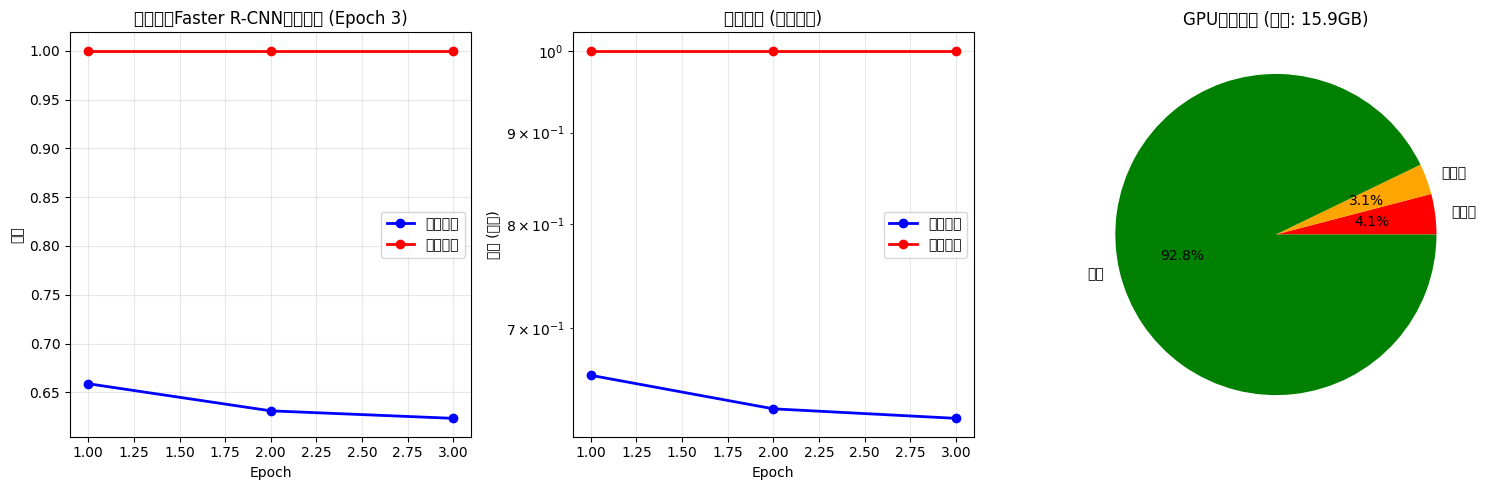

----------------------------------------------------------------------

üîÑ Epoch 4/12
----------------------------------------------------------------------


Epoch 4 - Training:   2%|‚ñè         | 102/5011 [00:12<11:38,  7.03it/s, Loss=0.5935, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5943
  rpn_cls_loss: 0.4123
  rpn_reg_loss: 0.0320
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:   4%|‚ñç         | 202/5011 [00:24<11:33,  6.93it/s, Loss=0.5931, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5923
  rpn_cls_loss: 0.4101
  rpn_reg_loss: 0.0322
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:   6%|‚ñå         | 302/5011 [00:35<11:16,  6.96it/s, Loss=0.5847, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5855
  rpn_cls_loss: 0.3992
  rpn_reg_loss: 0.0363
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:   8%|‚ñä         | 402/5011 [00:47<11:19,  6.78it/s, Loss=0.6174, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6180
  rpn_cls_loss: 0.4311
  rpn_reg_loss: 0.0370
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  10%|‚ñà         | 502/5011 [00:59<10:50,  6.93it/s, Loss=0.6230, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6230
  rpn_cls_loss: 0.4360
  rpn_reg_loss: 0.0370
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:11<10:34,  6.95it/s, Loss=0.6102, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6106
  rpn_cls_loss: 0.4228
  rpn_reg_loss: 0.0378
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:22<10:24,  6.89it/s, Loss=0.6172, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6161
  rpn_cls_loss: 0.4274
  rpn_reg_loss: 0.0387
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:05,  6.95it/s, Loss=0.6129, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6132
  rpn_cls_loss: 0.4239
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:59,  6.86it/s, Loss=0.6119, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6123
  rpn_cls_loss: 0.4227
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:58<09:42,  6.88it/s, Loss=0.6095, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6095
  rpn_cls_loss: 0.4206
  rpn_reg_loss: 0.0389
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:10<09:29,  6.87it/s, Loss=0.6104, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6106
  rpn_cls_loss: 0.4208
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:21<08:46,  7.24it/s, Loss=0.6130, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6126
  rpn_cls_loss: 0.4239
  rpn_reg_loss: 0.0387
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:33<08:53,  6.96it/s, Loss=0.6134, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6136
  rpn_cls_loss: 0.4242
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:45<08:13,  7.32it/s, Loss=0.6159, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6156
  rpn_cls_loss: 0.4257
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:57<08:21,  7.00it/s, Loss=0.6175, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6176
  rpn_cls_loss: 0.4273
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:08<08:10,  6.96it/s, Loss=0.6189, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6186
  rpn_cls_loss: 0.4281
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:20<07:58,  6.92it/s, Loss=0.6187, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6186
  rpn_cls_loss: 0.4274
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:32<07:44,  6.91it/s, Loss=0.6219, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6216
  rpn_cls_loss: 0.4300
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:44<07:28,  6.93it/s, Loss=0.6236, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6234
  rpn_cls_loss: 0.4316
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:56<07:16,  6.89it/s, Loss=0.6234, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6233
  rpn_cls_loss: 0.4317
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:07<06:41,  7.25it/s, Loss=0.6244, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6242
  rpn_cls_loss: 0.4329
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:18<06:26,  7.26it/s, Loss=0.6243, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6242
  rpn_cls_loss: 0.4331
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:30<06:14,  7.23it/s, Loss=0.6248, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6249
  rpn_cls_loss: 0.4338
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:41<06:19,  6.88it/s, Loss=0.6262, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6263
  rpn_cls_loss: 0.4348
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:53<06:00,  6.95it/s, Loss=0.6245, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6246
  rpn_cls_loss: 0.4323
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:05<05:32,  7.24it/s, Loss=0.6255, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6257
  rpn_cls_loss: 0.4334
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:17<05:39,  6.80it/s, Loss=0.6240, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6241
  rpn_cls_loss: 0.4317
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:29<05:24,  6.81it/s, Loss=0.6242, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6240
  rpn_cls_loss: 0.4319
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:40<05:06,  6.88it/s, Loss=0.6221, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6222
  rpn_cls_loss: 0.4300
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:52<04:48,  6.96it/s, Loss=0.6194, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6195
  rpn_cls_loss: 0.4276
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:04<04:39,  6.83it/s, Loss=0.6196, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6194
  rpn_cls_loss: 0.4276
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:16<04:25,  6.81it/s, Loss=0.6195, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6196
  rpn_cls_loss: 0.4278
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:28<04:10,  6.83it/s, Loss=0.6203, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6204
  rpn_cls_loss: 0.4287
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:40<03:51,  6.94it/s, Loss=0.6207, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6207
  rpn_cls_loss: 0.4292
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:51<03:39,  6.88it/s, Loss=0.6203, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6201
  rpn_cls_loss: 0.4283
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:03<03:23,  6.93it/s, Loss=0.6187, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6187
  rpn_cls_loss: 0.4270
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:15<03:12,  6.80it/s, Loss=0.6186, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6187
  rpn_cls_loss: 0.4267
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:27<03:00,  6.70it/s, Loss=0.6199, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6199
  rpn_cls_loss: 0.4278
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:39<02:41,  6.86it/s, Loss=0.6199, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6200
  rpn_cls_loss: 0.4283
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:51<02:24,  6.96it/s, Loss=0.6194, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6195
  rpn_cls_loss: 0.4281
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:02<02:13,  6.82it/s, Loss=0.6216, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6215
  rpn_cls_loss: 0.4301
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:14<01:57,  6.90it/s, Loss=0.6213, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6214
  rpn_cls_loss: 0.4296
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:26<01:42,  6.91it/s, Loss=0.6214, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6214
  rpn_cls_loss: 0.4299
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:38<01:29,  6.79it/s, Loss=0.6208, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6206
  rpn_cls_loss: 0.4292
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:50<01:13,  6.90it/s, Loss=0.6216, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6216
  rpn_cls_loss: 0.4301
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:02<00:59,  6.89it/s, Loss=0.6192, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6193
  rpn_cls_loss: 0.4278
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:14<00:45,  6.86it/s, Loss=0.6196, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6195
  rpn_cls_loss: 0.4281
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:26<00:30,  6.85it/s, Loss=0.6189, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6189
  rpn_cls_loss: 0.4274
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:37<00:16,  6.75it/s, Loss=0.6196, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6197
  rpn_cls_loss: 0.4277
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:49<00:01,  6.78it/s, Loss=0.6186, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6187
  rpn_cls_loss: 0.4267
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 4 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:50<00:00,  8.48it/s, Loss=0.6186, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 4 - Validation:   1%|          | 50/4952 [00:03<06:17, 13.00it/s, GT=132, Pred=0]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 0
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.000

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=0, Recall=0.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 4 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6186
  È™åËØÅÊçüÂ§±: 1.0000
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 9.9 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4266
    rpn_reg_loss: 0.04

Epoch 5 - Training:   2%|‚ñè         | 102/5011 [00:12<11:48,  6.93it/s, Loss=0.6166, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6187
  rpn_cls_loss: 0.4271
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:   4%|‚ñç         | 202/5011 [00:23<11:34,  6.92it/s, Loss=0.6420, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6435
  rpn_cls_loss: 0.4547
  rpn_reg_loss: 0.0388
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:   6%|‚ñå         | 302/5011 [00:35<10:49,  7.25it/s, Loss=0.6242, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6240
  rpn_cls_loss: 0.4367
  rpn_reg_loss: 0.0373
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:   8%|‚ñä         | 402/5011 [00:47<10:56,  7.02it/s, Loss=0.6229, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6214
  rpn_cls_loss: 0.4328
  rpn_reg_loss: 0.0386
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  10%|‚ñà         | 502/5011 [00:59<10:56,  6.86it/s, Loss=0.6173, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6175
  rpn_cls_loss: 0.4274
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:10<10:59,  6.68it/s, Loss=0.6171, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6171
  rpn_cls_loss: 0.4276
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:22<10:34,  6.80it/s, Loss=0.6101, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6102
  rpn_cls_loss: 0.4188
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:01,  6.99it/s, Loss=0.6074, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6073
  rpn_cls_loss: 0.4155
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:52,  6.93it/s, Loss=0.6152, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6146
  rpn_cls_loss: 0.4218
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:57<09:35,  6.97it/s, Loss=0.6178, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6181
  rpn_cls_loss: 0.4262
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:09<09:25,  6.91it/s, Loss=0.6158, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6159
  rpn_cls_loss: 0.4241
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:21<08:59,  7.06it/s, Loss=0.6116, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6118
  rpn_cls_loss: 0.4202
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:33<09:07,  6.78it/s, Loss=0.6142, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6144
  rpn_cls_loss: 0.4226
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:45<08:32,  7.04it/s, Loss=0.6154, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6155
  rpn_cls_loss: 0.4236
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:56<08:25,  6.94it/s, Loss=0.6111, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6112
  rpn_cls_loss: 0.4195
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:08<08:02,  7.06it/s, Loss=0.6134, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6135
  rpn_cls_loss: 0.4219
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:20<08:01,  6.87it/s, Loss=0.6120, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6118
  rpn_cls_loss: 0.4196
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:32<07:40,  6.96it/s, Loss=0.6125, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6125
  rpn_cls_loss: 0.4202
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:44<07:28,  6.94it/s, Loss=0.6105, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6106
  rpn_cls_loss: 0.4181
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:55<07:10,  6.99it/s, Loss=0.6134, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6136
  rpn_cls_loss: 0.4206
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:07<06:57,  6.97it/s, Loss=0.6140, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6141
  rpn_cls_loss: 0.4213
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:19<06:44,  6.94it/s, Loss=0.6120, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6121
  rpn_cls_loss: 0.4193
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:31<06:37,  6.81it/s, Loss=0.6101, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6099
  rpn_cls_loss: 0.4172
  rpn_reg_loss: 0.0427
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:43<06:29,  6.70it/s, Loss=0.6109, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6110
  rpn_cls_loss: 0.4181
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:55<06:13,  6.73it/s, Loss=0.6126, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6126
  rpn_cls_loss: 0.4195
  rpn_reg_loss: 0.0431
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:07<05:51,  6.86it/s, Loss=0.6111, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6111
  rpn_cls_loss: 0.4181
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:19<05:35,  6.87it/s, Loss=0.6116, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6116
  rpn_cls_loss: 0.4190
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:31<05:23,  6.82it/s, Loss=0.6118, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6118
  rpn_cls_loss: 0.4197
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:43<05:10,  6.79it/s, Loss=0.6111, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6111
  rpn_cls_loss: 0.4191
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:55<04:52,  6.87it/s, Loss=0.6106, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6107
  rpn_cls_loss: 0.4186
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:06<04:39,  6.84it/s, Loss=0.6102, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6102
  rpn_cls_loss: 0.4185
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:18<04:38,  6.50it/s, Loss=0.6122, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6122
  rpn_cls_loss: 0.4205
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:30<04:09,  6.85it/s, Loss=0.6136, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6137
  rpn_cls_loss: 0.4222
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:42<04:01,  6.66it/s, Loss=0.6136, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6135
  rpn_cls_loss: 0.4219
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:54<03:39,  6.87it/s, Loss=0.6128, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6128
  rpn_cls_loss: 0.4212
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:06<03:24,  6.90it/s, Loss=0.6131, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6131
  rpn_cls_loss: 0.4214
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:18<03:11,  6.82it/s, Loss=0.6135, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6135
  rpn_cls_loss: 0.4219
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:30<02:55,  6.87it/s, Loss=0.6127, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6127
  rpn_cls_loss: 0.4212
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:42<02:42,  6.84it/s, Loss=0.6127, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6127
  rpn_cls_loss: 0.4213
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:54<02:29,  6.74it/s, Loss=0.6144, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6144
  rpn_cls_loss: 0.4228
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:06<02:13,  6.82it/s, Loss=0.6130, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6129
  rpn_cls_loss: 0.4213
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:18<01:57,  6.91it/s, Loss=0.6127, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6127
  rpn_cls_loss: 0.4210
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:30<01:44,  6.77it/s, Loss=0.6117, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6116
  rpn_cls_loss: 0.4200
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:42<01:28,  6.84it/s, Loss=0.6113, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6113
  rpn_cls_loss: 0.4200
  rpn_reg_loss: 0.0413
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:53<01:14,  6.87it/s, Loss=0.6116, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6115
  rpn_cls_loss: 0.4197
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:05<00:59,  6.87it/s, Loss=0.6115, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6114
  rpn_cls_loss: 0.4200
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:17<00:45,  6.73it/s, Loss=0.6098, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6099
  rpn_cls_loss: 0.4185
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:29<00:30,  6.81it/s, Loss=0.6113, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6113
  rpn_cls_loss: 0.4198
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:42<00:16,  6.67it/s, Loss=0.6124, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6124
  rpn_cls_loss: 0.4208
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:54<00:01,  6.61it/s, Loss=0.6135, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6135
  rpn_cls_loss: 0.4219
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 5 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:55<00:00,  8.41it/s, Loss=0.6136, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 5 - Validation:   1%|          | 50/4952 [00:04<06:50, 11.95it/s, GT=132, Pred=0]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 0
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.000

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=0, Recall=0.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 5 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6136
  È™åËØÅÊçüÂ§±: 1.0000
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 10.0 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4220
    rpn_reg_loss: 0.0

Epoch 6 - Training:   2%|‚ñè         | 102/5011 [00:12<12:08,  6.74it/s, Loss=0.6495, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6533
  rpn_cls_loss: 0.4512
  rpn_reg_loss: 0.0520
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:   4%|‚ñç         | 202/5011 [00:24<11:45,  6.82it/s, Loss=0.6090, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6110
  rpn_cls_loss: 0.4121
  rpn_reg_loss: 0.0489
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:   6%|‚ñå         | 302/5011 [00:35<11:20,  6.92it/s, Loss=0.6138, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6145
  rpn_cls_loss: 0.4129
  rpn_reg_loss: 0.0515
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:   8%|‚ñä         | 402/5011 [00:47<11:06,  6.91it/s, Loss=0.6137, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6144
  rpn_cls_loss: 0.4125
  rpn_reg_loss: 0.0519
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  10%|‚ñà         | 502/5011 [00:59<10:47,  6.97it/s, Loss=0.6024, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6029
  rpn_cls_loss: 0.4058
  rpn_reg_loss: 0.0471
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:11<10:40,  6.88it/s, Loss=0.6001, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5996
  rpn_cls_loss: 0.4044
  rpn_reg_loss: 0.0453
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:23<10:24,  6.89it/s, Loss=0.5999, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6002
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0437
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:14,  6.85it/s, Loss=0.6048, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6046
  rpn_cls_loss: 0.4113
  rpn_reg_loss: 0.0433
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<10:00,  6.84it/s, Loss=0.6011, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6007
  rpn_cls_loss: 0.4086
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:58<09:46,  6.84it/s, Loss=0.6052, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6048
  rpn_cls_loss: 0.4122
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:10<09:38,  6.75it/s, Loss=0.6039, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6035
  rpn_cls_loss: 0.4103
  rpn_reg_loss: 0.0432
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:22<09:18,  6.81it/s, Loss=0.6066, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6065
  rpn_cls_loss: 0.4129
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:34<09:06,  6.79it/s, Loss=0.6072, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6074
  rpn_cls_loss: 0.4138
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:46<08:46,  6.86it/s, Loss=0.6024, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6025
  rpn_cls_loss: 0.4096
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:58<08:29,  6.89it/s, Loss=0.6075, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6070
  rpn_cls_loss: 0.4134
  rpn_reg_loss: 0.0437
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:09<08:36,  6.60it/s, Loss=0.6053, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6055
  rpn_cls_loss: 0.4127
  rpn_reg_loss: 0.0428
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:21<08:01,  6.88it/s, Loss=0.6035, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6037
  rpn_cls_loss: 0.4112
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:33<07:46,  6.88it/s, Loss=0.6042, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6044
  rpn_cls_loss: 0.4125
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:45<07:33,  6.85it/s, Loss=0.6068, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6065
  rpn_cls_loss: 0.4147
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:57<07:18,  6.87it/s, Loss=0.6074, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6074
  rpn_cls_loss: 0.4155
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:09<07:00,  6.92it/s, Loss=0.6058, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6059
  rpn_cls_loss: 0.4145
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:21<06:49,  6.85it/s, Loss=0.6048, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6049
  rpn_cls_loss: 0.4137
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:33<06:35,  6.84it/s, Loss=0.6053, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6053
  rpn_cls_loss: 0.4143
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:45<06:20,  6.86it/s, Loss=0.6032, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6033
  rpn_cls_loss: 0.4127
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:57<06:06,  6.84it/s, Loss=0.6044, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6042
  rpn_cls_loss: 0.4135
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:09<05:52,  6.84it/s, Loss=0.6045, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6045
  rpn_cls_loss: 0.4138
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:20<05:34,  6.91it/s, Loss=0.6051, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6051
  rpn_cls_loss: 0.4137
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:32<05:29,  6.70it/s, Loss=0.6061, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6057
  rpn_cls_loss: 0.4141
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:44<05:08,  6.85it/s, Loss=0.6064, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6065
  rpn_cls_loss: 0.4151
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:56<04:55,  6.81it/s, Loss=0.6070, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6071
  rpn_cls_loss: 0.4156
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:08<04:37,  6.89it/s, Loss=0.6073, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6073
  rpn_cls_loss: 0.4157
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:20<04:26,  6.78it/s, Loss=0.6060, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6058
  rpn_cls_loss: 0.4142
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:32<04:16,  6.67it/s, Loss=0.6056, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6057
  rpn_cls_loss: 0.4138
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:44<03:55,  6.83it/s, Loss=0.6053, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6053
  rpn_cls_loss: 0.4137
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:56<03:42,  6.80it/s, Loss=0.6075, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6076
  rpn_cls_loss: 0.4158
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:08<03:27,  6.80it/s, Loss=0.6076, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6075
  rpn_cls_loss: 0.4158
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:20<03:12,  6.82it/s, Loss=0.6083, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6081
  rpn_cls_loss: 0.4165
  rpn_reg_loss: 0.0416
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:32<02:56,  6.84it/s, Loss=0.6065, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6065
  rpn_cls_loss: 0.4150
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:44<02:36,  7.09it/s, Loss=0.6061, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6061
  rpn_cls_loss: 0.4147
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:56<02:29,  6.76it/s, Loss=0.6060, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6061
  rpn_cls_loss: 0.4149
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:08<02:13,  6.83it/s, Loss=0.6071, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6070
  rpn_cls_loss: 0.4156
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:20<01:58,  6.83it/s, Loss=0.6065, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6066
  rpn_cls_loss: 0.4154
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:32<01:43,  6.83it/s, Loss=0.6081, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6080
  rpn_cls_loss: 0.4168
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:44<01:28,  6.89it/s, Loss=0.6082, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6082
  rpn_cls_loss: 0.4173
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:56<01:14,  6.85it/s, Loss=0.6082, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6082
  rpn_cls_loss: 0.4174
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:08<01:00,  6.81it/s, Loss=0.6082, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6083
  rpn_cls_loss: 0.4172
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:20<00:45,  6.72it/s, Loss=0.6084, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6084
  rpn_cls_loss: 0.4176
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:32<00:31,  6.74it/s, Loss=0.6090, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6090
  rpn_cls_loss: 0.4180
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:44<00:15,  6.82it/s, Loss=0.6094, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6093
  rpn_cls_loss: 0.4181
  rpn_reg_loss: 0.0413
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:56<00:01,  6.80it/s, Loss=0.6099, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6099
  rpn_cls_loss: 0.4188
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 6 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:57<00:00,  8.38it/s, Loss=0.6101, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 6 - Validation:   1%|          | 50/4952 [00:03<06:25, 12.71it/s, GT=132, Pred=0]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 0
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.000

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=0, Recall=0.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 6 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6101
  È™åËØÅÊçüÂ§±: 1.0000
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 10.0 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4189
    rpn_reg_loss: 0.0

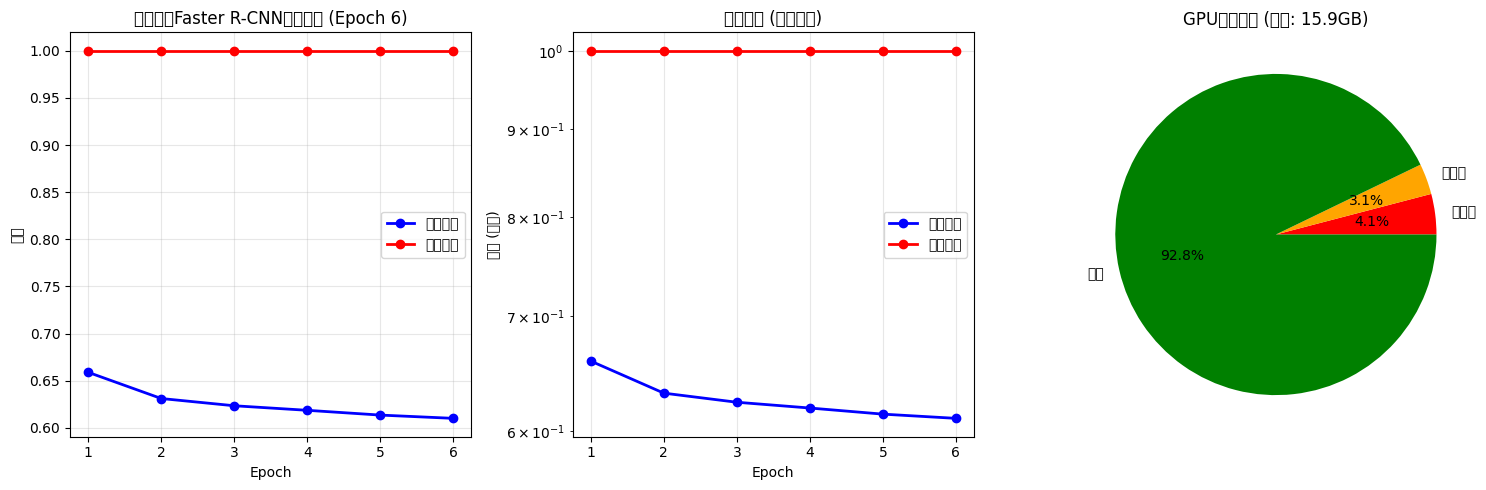

----------------------------------------------------------------------

üîÑ Epoch 7/12
----------------------------------------------------------------------


Epoch 7 - Training:   2%|‚ñè         | 102/5011 [00:12<11:50,  6.91it/s, Loss=0.5683, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5683
  rpn_cls_loss: 0.3797
  rpn_reg_loss: 0.0386
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:   4%|‚ñç         | 202/5011 [00:23<11:34,  6.93it/s, Loss=0.5655, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5665
  rpn_cls_loss: 0.3822
  rpn_reg_loss: 0.0342
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:   6%|‚ñå         | 302/5011 [00:35<11:12,  7.00it/s, Loss=0.5845, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5855
  rpn_cls_loss: 0.3983
  rpn_reg_loss: 0.0372
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:   8%|‚ñä         | 402/5011 [00:47<11:04,  6.94it/s, Loss=0.5934, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5937
  rpn_cls_loss: 0.4084
  rpn_reg_loss: 0.0353
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  10%|‚ñà         | 502/5011 [00:59<11:01,  6.81it/s, Loss=0.5888, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5888
  rpn_cls_loss: 0.4034
  rpn_reg_loss: 0.0354
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:11<10:35,  6.94it/s, Loss=0.5917, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5913
  rpn_cls_loss: 0.4029
  rpn_reg_loss: 0.0384
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:23<10:21,  6.93it/s, Loss=0.5892, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5892
  rpn_cls_loss: 0.4009
  rpn_reg_loss: 0.0383
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:05,  6.95it/s, Loss=0.5879, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5874
  rpn_cls_loss: 0.3989
  rpn_reg_loss: 0.0385
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:47,  6.99it/s, Loss=0.5907, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5909
  rpn_cls_loss: 0.4026
  rpn_reg_loss: 0.0383
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:58<09:43,  6.87it/s, Loss=0.5891, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5882
  rpn_cls_loss: 0.3990
  rpn_reg_loss: 0.0392
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:10<09:19,  6.99it/s, Loss=0.5893, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5894
  rpn_cls_loss: 0.4006
  rpn_reg_loss: 0.0388
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:22<09:07,  6.96it/s, Loss=0.5926, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5926
  rpn_cls_loss: 0.4037
  rpn_reg_loss: 0.0390
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:33<09:04,  6.82it/s, Loss=0.5978, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5979
  rpn_cls_loss: 0.4082
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:45<08:52,  6.78it/s, Loss=0.5963, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5962
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:57<08:47,  6.65it/s, Loss=0.5988, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5990
  rpn_cls_loss: 0.4084
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:09<08:17,  6.85it/s, Loss=0.5988, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5989
  rpn_cls_loss: 0.4089
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:21<08:04,  6.83it/s, Loss=0.5974, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5974
  rpn_cls_loss: 0.4074
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:33<07:33,  7.07it/s, Loss=0.5971, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5970
  rpn_cls_loss: 0.4066
  rpn_reg_loss: 0.0404
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:45<07:33,  6.86it/s, Loss=0.5965, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5965
  rpn_cls_loss: 0.4061
  rpn_reg_loss: 0.0404
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:57<07:10,  6.98it/s, Loss=0.5990, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5992
  rpn_cls_loss: 0.4094
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:09<06:58,  6.95it/s, Loss=0.6006, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6008
  rpn_cls_loss: 0.4109
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:20<06:50,  6.85it/s, Loss=0.5999, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6000
  rpn_cls_loss: 0.4094
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:32<06:32,  6.90it/s, Loss=0.5989, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5988
  rpn_cls_loss: 0.4085
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:44<06:21,  6.84it/s, Loss=0.5988, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5987
  rpn_cls_loss: 0.4082
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:56<06:06,  6.85it/s, Loss=0.5984, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5981
  rpn_cls_loss: 0.4075
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:08<05:56,  6.75it/s, Loss=0.5972, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5968
  rpn_cls_loss: 0.4068
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:20<05:29,  7.01it/s, Loss=0.5995, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5992
  rpn_cls_loss: 0.4090
  rpn_reg_loss: 0.0402
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:32<05:17,  6.96it/s, Loss=0.5998, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5999
  rpn_cls_loss: 0.4095
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:43<05:01,  6.99it/s, Loss=0.6010, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6011
  rpn_cls_loss: 0.4108
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:55<04:54,  6.82it/s, Loss=0.6021, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6018
  rpn_cls_loss: 0.4115
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:07<04:37,  6.88it/s, Loss=0.6025, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6025
  rpn_cls_loss: 0.4120
  rpn_reg_loss: 0.0405
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:19<04:21,  6.93it/s, Loss=0.6026, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6027
  rpn_cls_loss: 0.4120
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:31<04:09,  6.84it/s, Loss=0.6032, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6031
  rpn_cls_loss: 0.4121
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:43<03:52,  6.91it/s, Loss=0.6037, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6037
  rpn_cls_loss: 0.4128
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:55<03:40,  6.84it/s, Loss=0.6025, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6024
  rpn_cls_loss: 0.4117
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:07<03:28,  6.76it/s, Loss=0.6038, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6038
  rpn_cls_loss: 0.4131
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:19<03:11,  6.82it/s, Loss=0.6031, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6028
  rpn_cls_loss: 0.4120
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:31<02:57,  6.81it/s, Loss=0.6031, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6031
  rpn_cls_loss: 0.4124
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:43<02:43,  6.79it/s, Loss=0.6028, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6028
  rpn_cls_loss: 0.4122
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:55<02:27,  6.86it/s, Loss=0.6029, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6025
  rpn_cls_loss: 0.4119
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:07<02:13,  6.83it/s, Loss=0.6017, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6017
  rpn_cls_loss: 0.4113
  rpn_reg_loss: 0.0404
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:19<01:57,  6.90it/s, Loss=0.6028, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6028
  rpn_cls_loss: 0.4122
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:31<01:43,  6.82it/s, Loss=0.6021, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6021
  rpn_cls_loss: 0.4112
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:43<01:29,  6.81it/s, Loss=0.6028, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6028
  rpn_cls_loss: 0.4120
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:55<01:14,  6.85it/s, Loss=0.6025, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6026
  rpn_cls_loss: 0.4118
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:07<00:59,  6.83it/s, Loss=0.6028, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6028
  rpn_cls_loss: 0.4119
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:19<00:45,  6.82it/s, Loss=0.6043, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6043
  rpn_cls_loss: 0.4132
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:31<00:30,  6.80it/s, Loss=0.6042, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6043
  rpn_cls_loss: 0.4131
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:43<00:15,  6.82it/s, Loss=0.6048, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6048
  rpn_cls_loss: 0.4136
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:55<00:01,  6.80it/s, Loss=0.6048, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6049
  rpn_cls_loss: 0.4138
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 7 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:56<00:00,  8.40it/s, Loss=0.6046, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 7 - Validation:   1%|          | 50/4952 [00:03<06:30, 12.54it/s, GT=132, Pred=3]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 3
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.023

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=3, Recall=3.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 7 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6046
  È™åËØÅÊçüÂ§±: 0.9773
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000100
  ËÄóÊó∂: 10.0 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4136
    rpn_reg_loss: 0.0

Epoch 8 - Training:   2%|‚ñè         | 102/5011 [00:12<11:55,  6.86it/s, Loss=0.5935, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5857
  rpn_cls_loss: 0.3956
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:   4%|‚ñç         | 202/5011 [00:24<11:29,  6.98it/s, Loss=0.5883, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5884
  rpn_cls_loss: 0.3990
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:   6%|‚ñå         | 302/5011 [00:35<11:45,  6.67it/s, Loss=0.5901, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5912
  rpn_cls_loss: 0.4000
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:   8%|‚ñä         | 402/5011 [00:47<10:58,  7.00it/s, Loss=0.6000, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6003
  rpn_cls_loss: 0.4047
  rpn_reg_loss: 0.0456
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  10%|‚ñà         | 502/5011 [00:59<10:55,  6.88it/s, Loss=0.6006, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6008
  rpn_cls_loss: 0.4075
  rpn_reg_loss: 0.0432
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:11<10:35,  6.93it/s, Loss=0.5951, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5956
  rpn_cls_loss: 0.4021
  rpn_reg_loss: 0.0435
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:23<10:27,  6.87it/s, Loss=0.6052, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6054
  rpn_cls_loss: 0.4120
  rpn_reg_loss: 0.0434
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<10:07,  6.92it/s, Loss=0.6114, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6107
  rpn_cls_loss: 0.4169
  rpn_reg_loss: 0.0438
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:59,  6.86it/s, Loss=0.6052, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6054
  rpn_cls_loss: 0.4112
  rpn_reg_loss: 0.0441
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:58<09:45,  6.84it/s, Loss=0.6088, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6088
  rpn_cls_loss: 0.4152
  rpn_reg_loss: 0.0436
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:10<09:29,  6.87it/s, Loss=0.6080, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6081
  rpn_cls_loss: 0.4155
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:22<08:41,  7.30it/s, Loss=0.6085, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6087
  rpn_cls_loss: 0.4162
  rpn_reg_loss: 0.0425
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:34<09:09,  6.75it/s, Loss=0.6057, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6053
  rpn_cls_loss: 0.4130
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:46<08:48,  6.83it/s, Loss=0.6019, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6021
  rpn_cls_loss: 0.4099
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:57<08:37,  6.78it/s, Loss=0.6012, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6014
  rpn_cls_loss: 0.4093
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:09<08:18,  6.85it/s, Loss=0.6006, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6006
  rpn_cls_loss: 0.4089
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:21<08:04,  6.83it/s, Loss=0.5987, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5987
  rpn_cls_loss: 0.4071
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:33<07:50,  6.82it/s, Loss=0.6006, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6004
  rpn_cls_loss: 0.4080
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:45<07:51,  6.59it/s, Loss=0.5989, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5990
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:57<07:15,  6.90it/s, Loss=0.6023, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6024
  rpn_cls_loss: 0.4097
  rpn_reg_loss: 0.0427
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:09<07:08,  6.79it/s, Loss=0.6019, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6019
  rpn_cls_loss: 0.4093
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:21<06:48,  6.87it/s, Loss=0.6014, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6015
  rpn_cls_loss: 0.4085
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:33<06:42,  6.74it/s, Loss=0.6013, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6012
  rpn_cls_loss: 0.4083
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:45<06:20,  6.86it/s, Loss=0.6004, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6004
  rpn_cls_loss: 0.4078
  rpn_reg_loss: 0.0426
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:57<06:06,  6.85it/s, Loss=0.5990, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5989
  rpn_cls_loss: 0.4061
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:08<05:49,  6.90it/s, Loss=0.5996, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5996
  rpn_cls_loss: 0.4069
  rpn_reg_loss: 0.0427
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:20<05:37,  6.84it/s, Loss=0.6002, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6003
  rpn_cls_loss: 0.4079
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:32<05:25,  6.79it/s, Loss=0.5997, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5998
  rpn_cls_loss: 0.4074
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:44<05:08,  6.85it/s, Loss=0.5982, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5980
  rpn_cls_loss: 0.4057
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:56<04:57,  6.76it/s, Loss=0.5981, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5980
  rpn_cls_loss: 0.4058
  rpn_reg_loss: 0.0423
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:08<04:42,  6.76it/s, Loss=0.5980, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5980
  rpn_cls_loss: 0.4060
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:20<04:24,  6.85it/s, Loss=0.5981, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5982
  rpn_cls_loss: 0.4063
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:32<04:22,  6.51it/s, Loss=0.5993, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5992
  rpn_cls_loss: 0.4074
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:44<03:55,  6.84it/s, Loss=0.6007, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6008
  rpn_cls_loss: 0.4094
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:56<03:40,  6.84it/s, Loss=0.6001, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6002
  rpn_cls_loss: 0.4088
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [07:08<03:27,  6.78it/s, Loss=0.6012, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6013
  rpn_cls_loss: 0.4098
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:20<03:12,  6.79it/s, Loss=0.6008, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6009
  rpn_cls_loss: 0.4096
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:32<02:58,  6.76it/s, Loss=0.6017, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6017
  rpn_cls_loss: 0.4106
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:44<02:42,  6.82it/s, Loss=0.6013, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6014
  rpn_cls_loss: 0.4103
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:56<02:28,  6.78it/s, Loss=0.6000, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6000
  rpn_cls_loss: 0.4088
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [08:08<02:12,  6.88it/s, Loss=0.6001, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6000
  rpn_cls_loss: 0.4090
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:20<01:58,  6.83it/s, Loss=0.5998, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5999
  rpn_cls_loss: 0.4088
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:32<01:42,  6.91it/s, Loss=0.6012, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6012
  rpn_cls_loss: 0.4103
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:44<01:28,  6.86it/s, Loss=0.6012, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6012
  rpn_cls_loss: 0.4105
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:56<01:14,  6.79it/s, Loss=0.6007, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6007
  rpn_cls_loss: 0.4101
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [09:08<00:58,  7.00it/s, Loss=0.5993, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5994
  rpn_cls_loss: 0.4086
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:20<00:45,  6.83it/s, Loss=0.5999, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5999
  rpn_cls_loss: 0.4090
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:32<00:29,  6.97it/s, Loss=0.6005, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6005
  rpn_cls_loss: 0.4098
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:44<00:15,  6.90it/s, Loss=0.6006, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6006
  rpn_cls_loss: 0.4100
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:56<00:01,  6.73it/s, Loss=0.6006, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6006
  rpn_cls_loss: 0.4100
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 8 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:57<00:00,  8.38it/s, Loss=0.6007, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 8 - Validation:   1%|          | 50/4952 [00:03<06:29, 12.60it/s, GT=132, Pred=2]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 2
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.015

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=1, Recall=1.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=1, Recall=0.333
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 8 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.6007
  È™åËØÅÊçüÂ§±: 0.9848
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000010
  ËÄóÊó∂: 10.0 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4101
    rpn_reg_loss: 0.0

Epoch 9 - Training:   2%|‚ñè         | 102/5011 [00:12<11:18,  7.24it/s, Loss=0.5967, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5979
  rpn_cls_loss: 0.4153
  rpn_reg_loss: 0.0325
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:   4%|‚ñç         | 202/5011 [00:23<11:45,  6.82it/s, Loss=0.6048, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6061
  rpn_cls_loss: 0.4139
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:   6%|‚ñå         | 302/5011 [00:35<11:14,  6.98it/s, Loss=0.5991, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5995
  rpn_cls_loss: 0.4073
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:   8%|‚ñä         | 402/5011 [00:47<11:10,  6.88it/s, Loss=0.6188, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6187
  rpn_cls_loss: 0.4270
  rpn_reg_loss: 0.0418
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  10%|‚ñà         | 502/5011 [00:59<11:10,  6.72it/s, Loss=0.6206, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6209
  rpn_cls_loss: 0.4287
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:11<10:44,  6.84it/s, Loss=0.6183, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6188
  rpn_cls_loss: 0.4290
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:23<10:34,  6.80it/s, Loss=0.6160, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6160
  rpn_cls_loss: 0.4263
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:34<09:44,  7.20it/s, Loss=0.6119, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6122
  rpn_cls_loss: 0.4236
  rpn_reg_loss: 0.0385
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:46<09:41,  7.07it/s, Loss=0.6057, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6052
  rpn_cls_loss: 0.4169
  rpn_reg_loss: 0.0383
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:57<09:22,  7.13it/s, Loss=0.6033, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6035
  rpn_cls_loss: 0.4160
  rpn_reg_loss: 0.0375
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:09<09:08,  7.12it/s, Loss=0.6007, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6004
  rpn_cls_loss: 0.4123
  rpn_reg_loss: 0.0381
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:20<08:50,  7.18it/s, Loss=0.6016, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6014
  rpn_cls_loss: 0.4129
  rpn_reg_loss: 0.0385
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:32<08:35,  7.20it/s, Loss=0.6009, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6011
  rpn_cls_loss: 0.4126
  rpn_reg_loss: 0.0385
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:44<08:46,  6.86it/s, Loss=0.6021, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6015
  rpn_cls_loss: 0.4132
  rpn_reg_loss: 0.0383
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:55<07:55,  7.37it/s, Loss=0.5992, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5989
  rpn_cls_loss: 0.4099
  rpn_reg_loss: 0.0390
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:06<07:46,  7.31it/s, Loss=0.5952, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5952
  rpn_cls_loss: 0.4068
  rpn_reg_loss: 0.0384
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:18<07:41,  7.17it/s, Loss=0.5941, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5942
  rpn_cls_loss: 0.4058
  rpn_reg_loss: 0.0384
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:30<07:22,  7.25it/s, Loss=0.5960, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5962
  rpn_cls_loss: 0.4071
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:41<07:07,  7.28it/s, Loss=0.5982, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5981
  rpn_cls_loss: 0.4095
  rpn_reg_loss: 0.0386
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:53<07:00,  7.15it/s, Loss=0.5986, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5987
  rpn_cls_loss: 0.4104
  rpn_reg_loss: 0.0383
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:04<06:45,  7.17it/s, Loss=0.5970, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5970
  rpn_cls_loss: 0.4079
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:16<06:24,  7.30it/s, Loss=0.5995, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5992
  rpn_cls_loss: 0.4099
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:27<06:08,  7.35it/s, Loss=0.5999, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5994
  rpn_cls_loss: 0.4102
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:39<05:57,  7.30it/s, Loss=0.6002, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6002
  rpn_cls_loss: 0.4108
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:50<05:45,  7.27it/s, Loss=0.5979, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5980
  rpn_cls_loss: 0.4089
  rpn_reg_loss: 0.0390
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:02<05:37,  7.14it/s, Loss=0.5963, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5964
  rpn_cls_loss: 0.4076
  rpn_reg_loss: 0.0388
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:13<05:22,  7.16it/s, Loss=0.5973, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5974
  rpn_cls_loss: 0.4086
  rpn_reg_loss: 0.0389
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:25<05:06,  7.20it/s, Loss=0.5969, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5969
  rpn_cls_loss: 0.4079
  rpn_reg_loss: 0.0390
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:36<04:50,  7.26it/s, Loss=0.5970, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5968
  rpn_cls_loss: 0.4072
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:48<04:40,  7.17it/s, Loss=0.5973, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5973
  rpn_cls_loss: 0.4073
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:00<04:24,  7.22it/s, Loss=0.5971, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5972
  rpn_cls_loss: 0.4073
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:11<04:11,  7.19it/s, Loss=0.5968, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5969
  rpn_cls_loss: 0.4070
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:23<04:03,  7.01it/s, Loss=0.5972, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5972
  rpn_cls_loss: 0.4076
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:35<03:43,  7.21it/s, Loss=0.5968, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5966
  rpn_cls_loss: 0.4070
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:46<03:28,  7.23it/s, Loss=0.5980, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5980
  rpn_cls_loss: 0.4087
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [06:58<03:18,  7.09it/s, Loss=0.5987, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5987
  rpn_cls_loss: 0.4092
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:10<03:00,  7.27it/s, Loss=0.5980, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5978
  rpn_cls_loss: 0.4085
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:21<02:46,  7.26it/s, Loss=0.5970, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5970
  rpn_cls_loss: 0.4079
  rpn_reg_loss: 0.0392
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:33<02:35,  7.13it/s, Loss=0.5961, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5962
  rpn_cls_loss: 0.4071
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:45<02:18,  7.29it/s, Loss=0.5952, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5952
  rpn_cls_loss: 0.4060
  rpn_reg_loss: 0.0392
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [07:56<02:05,  7.23it/s, Loss=0.5964, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5965
  rpn_cls_loss: 0.4071
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:08<01:52,  7.18it/s, Loss=0.5959, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5960
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:20<01:39,  7.16it/s, Loss=0.5961, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5961
  rpn_cls_loss: 0.4065
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:31<01:24,  7.24it/s, Loss=0.5954, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5953
  rpn_cls_loss: 0.4057
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:43<01:12,  7.00it/s, Loss=0.5948, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5948
  rpn_cls_loss: 0.4052
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [08:55<00:57,  7.16it/s, Loss=0.5944, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5944
  rpn_cls_loss: 0.4045
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:06<00:43,  7.09it/s, Loss=0.5953, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5952
  rpn_cls_loss: 0.4055
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:18<00:29,  7.15it/s, Loss=0.5946, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5946
  rpn_cls_loss: 0.4050
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:30<00:15,  7.22it/s, Loss=0.5935, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5935
  rpn_cls_loss: 0.4039
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:41<00:01,  7.13it/s, Loss=0.5937, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5936
  rpn_cls_loss: 0.4038
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 9 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:42<00:00,  8.60it/s, Loss=0.5939, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 9 - Validation:   1%|          | 50/4952 [00:03<06:10, 13.22it/s, GT=132, Pred=3]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 3
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.023

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=3, Recall=3.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 9 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.5939
  È™åËØÅÊçüÂ§±: 0.9773
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000010
  ËÄóÊó∂: 9.8 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4042
    rpn_reg_loss: 0.03

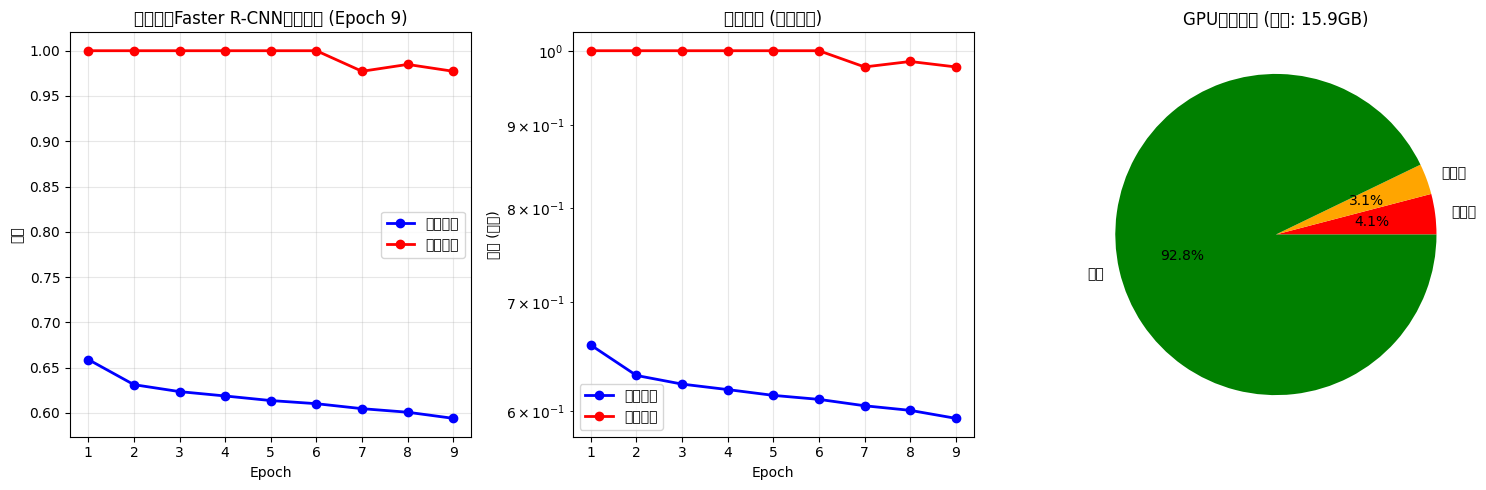

----------------------------------------------------------------------

üîÑ Epoch 10/12
----------------------------------------------------------------------


Epoch 10 - Training:   2%|‚ñè         | 102/5011 [00:11<11:16,  7.26it/s, Loss=0.5962, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5904
  rpn_cls_loss: 0.3912
  rpn_reg_loss: 0.0492
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:   4%|‚ñç         | 202/5011 [00:23<10:58,  7.30it/s, Loss=0.5489, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5491
  rpn_cls_loss: 0.3628
  rpn_reg_loss: 0.0364
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:   6%|‚ñå         | 302/5011 [00:34<10:44,  7.30it/s, Loss=0.5596, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5603
  rpn_cls_loss: 0.3710
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:   8%|‚ñä         | 402/5011 [00:46<10:33,  7.28it/s, Loss=0.5835, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5841
  rpn_cls_loss: 0.3942
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  10%|‚ñà         | 502/5011 [00:58<10:20,  7.27it/s, Loss=0.5928, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5930
  rpn_cls_loss: 0.4016
  rpn_reg_loss: 0.0414
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:09<10:14,  7.18it/s, Loss=0.6057, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6062
  rpn_cls_loss: 0.4132
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:21<09:56,  7.22it/s, Loss=0.6083, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6088
  rpn_cls_loss: 0.4158
  rpn_reg_loss: 0.0429
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:33<09:40,  7.25it/s, Loss=0.6025, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6029
  rpn_cls_loss: 0.4099
  rpn_reg_loss: 0.0430
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:44<09:36,  7.12it/s, Loss=0.6018, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6021
  rpn_cls_loss: 0.4102
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:56<09:13,  7.24it/s, Loss=0.6010, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6010
  rpn_cls_loss: 0.4091
  rpn_reg_loss: 0.0419
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:08<08:58,  7.25it/s, Loss=0.5979, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5982
  rpn_cls_loss: 0.4070
  rpn_reg_loss: 0.0412
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:19<08:47,  7.22it/s, Loss=0.6001, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6004
  rpn_cls_loss: 0.4096
  rpn_reg_loss: 0.0408
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:31<08:36,  7.18it/s, Loss=0.5970, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5970
  rpn_cls_loss: 0.4063
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:43<08:33,  7.03it/s, Loss=0.6000, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6002
  rpn_cls_loss: 0.4099
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:54<08:16,  7.07it/s, Loss=0.5990, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5992
  rpn_cls_loss: 0.4086
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:06<07:48,  7.27it/s, Loss=0.5988, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5983
  rpn_cls_loss: 0.4087
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:18<07:40,  7.18it/s, Loss=0.5989, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5987
  rpn_cls_loss: 0.4086
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:29<07:22,  7.26it/s, Loss=0.5991, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5992
  rpn_cls_loss: 0.4097
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:41<07:26,  6.96it/s, Loss=0.5994, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5993
  rpn_cls_loss: 0.4098
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:53<06:56,  7.22it/s, Loss=0.5975, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5976
  rpn_cls_loss: 0.4084
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:04<06:45,  7.17it/s, Loss=0.5965, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5959
  rpn_cls_loss: 0.4063
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:16<06:31,  7.18it/s, Loss=0.5971, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5972
  rpn_cls_loss: 0.4078
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:27<06:12,  7.27it/s, Loss=0.5998, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5998
  rpn_cls_loss: 0.4098
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:39<06:03,  7.17it/s, Loss=0.6008, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6008
  rpn_cls_loss: 0.4107
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:51<05:46,  7.24it/s, Loss=0.5985, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5983
  rpn_cls_loss: 0.4084
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:02<05:34,  7.20it/s, Loss=0.5983, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5981
  rpn_cls_loss: 0.4083
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:14<05:35,  6.89it/s, Loss=0.6008, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6005
  rpn_cls_loss: 0.4109
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:26<04:59,  7.37it/s, Loss=0.5990, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5989
  rpn_cls_loss: 0.4093
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:37<04:54,  7.15it/s, Loss=0.5989, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5990
  rpn_cls_loss: 0.4096
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:49<04:35,  7.28it/s, Loss=0.6003, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6003
  rpn_cls_loss: 0.4106
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:00<04:22,  7.28it/s, Loss=0.6015, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6015
  rpn_cls_loss: 0.4119
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:12<04:08,  7.29it/s, Loss=0.6010, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6011
  rpn_cls_loss: 0.4113
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:23<03:54,  7.30it/s, Loss=0.6001, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6002
  rpn_cls_loss: 0.4104
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:35<03:41,  7.26it/s, Loss=0.6007, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.6007
  rpn_cls_loss: 0.4110
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:47<03:28,  7.23it/s, Loss=0.5994, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5995
  rpn_cls_loss: 0.4098
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [06:58<03:12,  7.30it/s, Loss=0.5982, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5982
  rpn_cls_loss: 0.4089
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:10<02:58,  7.32it/s, Loss=0.5978, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5979
  rpn_cls_loss: 0.4085
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:21<02:46,  7.27it/s, Loss=0.5968, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5967
  rpn_cls_loss: 0.4072
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:33<02:34,  7.16it/s, Loss=0.5961, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5962
  rpn_cls_loss: 0.4069
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:45<02:20,  7.21it/s, Loss=0.5965, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5964
  rpn_cls_loss: 0.4071
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [07:57<02:07,  7.15it/s, Loss=0.5959, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5956
  rpn_cls_loss: 0.4065
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:08<01:54,  7.07it/s, Loss=0.5949, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5950
  rpn_cls_loss: 0.4056
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:20<01:42,  6.95it/s, Loss=0.5961, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5960
  rpn_cls_loss: 0.4062
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:32<01:23,  7.31it/s, Loss=0.5969, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5969
  rpn_cls_loss: 0.4070
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:43<01:10,  7.26it/s, Loss=0.5967, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5968
  rpn_cls_loss: 0.4069
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [08:55<00:58,  6.98it/s, Loss=0.5968, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5969
  rpn_cls_loss: 0.4069
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:07<00:42,  7.23it/s, Loss=0.5978, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5978
  rpn_cls_loss: 0.4076
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:18<00:29,  7.10it/s, Loss=0.5957, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5957
  rpn_cls_loss: 0.4056
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:30<00:16,  6.66it/s, Loss=0.5966, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5965
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:42<00:01,  6.93it/s, Loss=0.5962, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5963
  rpn_cls_loss: 0.4065
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 10 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:43<00:00,  8.59it/s, Loss=0.5963, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 10 - Validation:   1%|          | 50/4952 [00:03<06:18, 12.95it/s, GT=132, Pred=3]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 3
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.023

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=3, Recall=3.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 10 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.5963
  È™åËØÅÊçüÂ§±: 0.9773
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000010
  ËÄóÊó∂: 9.8 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4066
    rpn_reg_loss: 0.0

Epoch 11 - Training:   2%|‚ñè         | 102/5011 [00:11<11:18,  7.23it/s, Loss=0.5530, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5548
  rpn_cls_loss: 0.3645
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:   4%|‚ñç         | 202/5011 [00:23<11:16,  7.11it/s, Loss=0.5762, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5745
  rpn_cls_loss: 0.3891
  rpn_reg_loss: 0.0354
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:   6%|‚ñå         | 302/5011 [00:35<11:06,  7.06it/s, Loss=0.5745, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5743
  rpn_cls_loss: 0.3872
  rpn_reg_loss: 0.0370
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:   8%|‚ñä         | 402/5011 [00:46<10:55,  7.03it/s, Loss=0.5795, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5799
  rpn_cls_loss: 0.3926
  rpn_reg_loss: 0.0373
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  10%|‚ñà         | 502/5011 [00:58<10:27,  7.19it/s, Loss=0.5805, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5810
  rpn_cls_loss: 0.3928
  rpn_reg_loss: 0.0382
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:10<10:08,  7.25it/s, Loss=0.5907, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5908
  rpn_cls_loss: 0.4014
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:21<10:03,  7.14it/s, Loss=0.5937, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5940
  rpn_cls_loss: 0.4031
  rpn_reg_loss: 0.0409
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:33<10:00,  7.00it/s, Loss=0.5920, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5912
  rpn_cls_loss: 0.4009
  rpn_reg_loss: 0.0404
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:44<09:20,  7.34it/s, Loss=0.5885, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5887
  rpn_cls_loss: 0.3986
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:56<09:13,  7.25it/s, Loss=0.5923, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5925
  rpn_cls_loss: 0.4014
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:08<09:08,  7.12it/s, Loss=0.5963, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5958
  rpn_cls_loss: 0.4046
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:19<08:54,  7.13it/s, Loss=0.5929, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5925
  rpn_cls_loss: 0.4022
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:31<08:39,  7.14it/s, Loss=0.5950, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5950
  rpn_cls_loss: 0.4053
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:43<08:08,  7.39it/s, Loss=0.5935, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5936
  rpn_cls_loss: 0.4034
  rpn_reg_loss: 0.0402
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:54<08:08,  7.19it/s, Loss=0.5921, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5922
  rpn_cls_loss: 0.4016
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:06<07:50,  7.24it/s, Loss=0.5904, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5906
  rpn_cls_loss: 0.4000
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:17<07:35,  7.27it/s, Loss=0.5920, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5921
  rpn_cls_loss: 0.4020
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:29<07:22,  7.25it/s, Loss=0.5934, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5934
  rpn_cls_loss: 0.4032
  rpn_reg_loss: 0.0402
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:41<07:10,  7.23it/s, Loss=0.5938, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5938
  rpn_cls_loss: 0.4031
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:52<06:51,  7.31it/s, Loss=0.5934, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5931
  rpn_cls_loss: 0.4026
  rpn_reg_loss: 0.0404
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:04<06:43,  7.22it/s, Loss=0.5952, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5952
  rpn_cls_loss: 0.4045
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:16<06:38,  7.04it/s, Loss=0.5952, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5953
  rpn_cls_loss: 0.4042
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:27<06:18,  7.15it/s, Loss=0.5947, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5948
  rpn_cls_loss: 0.4035
  rpn_reg_loss: 0.0413
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:39<05:58,  7.27it/s, Loss=0.5959, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5960
  rpn_cls_loss: 0.4051
  rpn_reg_loss: 0.0410
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:50<05:47,  7.22it/s, Loss=0.5956, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5957
  rpn_cls_loss: 0.4050
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [05:02<05:31,  7.27it/s, Loss=0.5959, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5957
  rpn_cls_loss: 0.4053
  rpn_reg_loss: 0.0405
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:14<05:19,  7.23it/s, Loss=0.5963, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5964
  rpn_cls_loss: 0.4060
  rpn_reg_loss: 0.0404
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:25<05:03,  7.28it/s, Loss=0.5963, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5963
  rpn_cls_loss: 0.4058
  rpn_reg_loss: 0.0405
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:37<04:55,  7.13it/s, Loss=0.5986, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5986
  rpn_cls_loss: 0.4079
  rpn_reg_loss: 0.0407
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:49<04:42,  7.12it/s, Loss=0.5978, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5976
  rpn_cls_loss: 0.4071
  rpn_reg_loss: 0.0405
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [06:00<04:35,  6.93it/s, Loss=0.5966, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5966
  rpn_cls_loss: 0.4063
  rpn_reg_loss: 0.0403
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:12<04:11,  7.19it/s, Loss=0.5973, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5974
  rpn_cls_loss: 0.4074
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:24<03:57,  7.19it/s, Loss=0.5965, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5966
  rpn_cls_loss: 0.4067
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:35<03:42,  7.23it/s, Loss=0.5952, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5953
  rpn_cls_loss: 0.4055
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:47<03:30,  7.16it/s, Loss=0.5954, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5955
  rpn_cls_loss: 0.4057
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [06:59<03:17,  7.14it/s, Loss=0.5938, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5938
  rpn_cls_loss: 0.4039
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:10<03:03,  7.12it/s, Loss=0.5943, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5942
  rpn_cls_loss: 0.4042
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:22<02:46,  7.26it/s, Loss=0.5952, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5951
  rpn_cls_loss: 0.4052
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:34<02:32,  7.25it/s, Loss=0.5950, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5948
  rpn_cls_loss: 0.4049
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:45<02:20,  7.21it/s, Loss=0.5954, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5953
  rpn_cls_loss: 0.4054
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [07:57<02:07,  7.15it/s, Loss=0.5956, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5956
  rpn_cls_loss: 0.4057
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:08<01:51,  7.25it/s, Loss=0.5949, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5948
  rpn_cls_loss: 0.4049
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:20<01:38,  7.17it/s, Loss=0.5942, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5942
  rpn_cls_loss: 0.4041
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:32<01:28,  6.87it/s, Loss=0.5943, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5942
  rpn_cls_loss: 0.4044
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:44<01:12,  6.99it/s, Loss=0.5928, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5928
  rpn_cls_loss: 0.4031
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [08:56<01:00,  6.73it/s, Loss=0.5930, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5930
  rpn_cls_loss: 0.4032
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:08<00:45,  6.79it/s, Loss=0.5935, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5935
  rpn_cls_loss: 0.4036
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:20<00:30,  6.95it/s, Loss=0.5949, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5949
  rpn_cls_loss: 0.4051
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:32<00:15,  6.94it/s, Loss=0.5955, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5956
  rpn_cls_loss: 0.4056
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:44<00:01,  7.15it/s, Loss=0.5955, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5955
  rpn_cls_loss: 0.4058
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 11 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:45<00:00,  8.55it/s, Loss=0.5956, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 11 - Validation:   1%|          | 50/4952 [00:03<06:28, 12.61it/s, GT=132, Pred=3]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 3
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.023

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=3, Recall=3.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 11 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.5956
  È™åËØÅÊçüÂ§±: 0.9773
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000010
  ËÄóÊó∂: 9.8 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4058
    rpn_reg_loss: 0.0

Epoch 12 - Training:   2%|‚ñè         | 102/5011 [00:12<11:49,  6.92it/s, Loss=0.5732, Success=102/102]


üìä Batch 100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5757
  rpn_cls_loss: 0.3921
  rpn_reg_loss: 0.0336
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:   4%|‚ñç         | 202/5011 [00:23<12:11,  6.57it/s, Loss=0.5601, Success=202/202]


üìä Batch 200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5611
  rpn_cls_loss: 0.3729
  rpn_reg_loss: 0.0382
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:   6%|‚ñå         | 302/5011 [00:35<10:57,  7.16it/s, Loss=0.5706, Success=302/302]


üìä Batch 300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5715
  rpn_cls_loss: 0.3836
  rpn_reg_loss: 0.0379
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:   8%|‚ñä         | 402/5011 [00:47<10:40,  7.19it/s, Loss=0.5767, Success=402/402]


üìä Batch 400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5775
  rpn_cls_loss: 0.3874
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  10%|‚ñà         | 502/5011 [00:58<10:12,  7.37it/s, Loss=0.5725, Success=502/502]


üìä Batch 500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5729
  rpn_cls_loss: 0.3827
  rpn_reg_loss: 0.0402
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  12%|‚ñà‚ñè        | 602/5011 [01:09<09:54,  7.42it/s, Loss=0.5722, Success=602/602]


üìä Batch 600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5727
  rpn_cls_loss: 0.3828
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  14%|‚ñà‚ñç        | 702/5011 [01:21<09:45,  7.36it/s, Loss=0.5808, Success=702/702]


üìä Batch 700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5811
  rpn_cls_loss: 0.3889
  rpn_reg_loss: 0.0422
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  16%|‚ñà‚ñå        | 802/5011 [01:32<09:37,  7.29it/s, Loss=0.5883, Success=802/802]


üìä Batch 800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5871
  rpn_cls_loss: 0.3944
  rpn_reg_loss: 0.0427
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  18%|‚ñà‚ñä        | 902/5011 [01:44<09:23,  7.29it/s, Loss=0.5923, Success=902/902]


üìä Batch 900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5923
  rpn_cls_loss: 0.4004
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  20%|‚ñà‚ñâ        | 1002/5011 [01:55<09:12,  7.26it/s, Loss=0.5902, Success=1002/1002]


üìä Batch 1000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5903
  rpn_cls_loss: 0.3982
  rpn_reg_loss: 0.0421
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  22%|‚ñà‚ñà‚ñè       | 1102/5011 [02:07<09:07,  7.14it/s, Loss=0.5896, Success=1102/1102]


üìä Batch 1100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5898
  rpn_cls_loss: 0.3987
  rpn_reg_loss: 0.0411
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  24%|‚ñà‚ñà‚ñç       | 1202/5011 [02:18<08:39,  7.33it/s, Loss=0.5905, Success=1202/1202]


üìä Batch 1200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5901
  rpn_cls_loss: 0.3985
  rpn_reg_loss: 0.0415
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  26%|‚ñà‚ñà‚ñå       | 1302/5011 [02:30<09:59,  6.19it/s, Loss=0.5894, Success=1302/1302]


üìä Batch 1300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5895
  rpn_cls_loss: 0.3975
  rpn_reg_loss: 0.0420
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  28%|‚ñà‚ñà‚ñä       | 1402/5011 [02:41<08:12,  7.32it/s, Loss=0.5905, Success=1402/1402]


üìä Batch 1400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5908
  rpn_cls_loss: 0.3984
  rpn_reg_loss: 0.0424
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  30%|‚ñà‚ñà‚ñâ       | 1502/5011 [02:53<08:02,  7.27it/s, Loss=0.5877, Success=1502/1502]


üìä Batch 1500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5877
  rpn_cls_loss: 0.3959
  rpn_reg_loss: 0.0417
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  32%|‚ñà‚ñà‚ñà‚ñè      | 1602/5011 [03:04<07:44,  7.34it/s, Loss=0.5885, Success=1602/1602]


üìä Batch 1600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5885
  rpn_cls_loss: 0.3972
  rpn_reg_loss: 0.0413
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  34%|‚ñà‚ñà‚ñà‚ñç      | 1702/5011 [03:16<07:33,  7.29it/s, Loss=0.5851, Success=1702/1702]


üìä Batch 1700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5853
  rpn_cls_loss: 0.3947
  rpn_reg_loss: 0.0406
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  36%|‚ñà‚ñà‚ñà‚ñå      | 1802/5011 [03:27<07:28,  7.15it/s, Loss=0.5867, Success=1802/1802]


üìä Batch 1800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5864
  rpn_cls_loss: 0.3962
  rpn_reg_loss: 0.0402
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  38%|‚ñà‚ñà‚ñà‚ñä      | 1902/5011 [03:39<07:08,  7.25it/s, Loss=0.5856, Success=1902/1902]


üìä Batch 1900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5856
  rpn_cls_loss: 0.3959
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  40%|‚ñà‚ñà‚ñà‚ñâ      | 2002/5011 [03:50<06:50,  7.34it/s, Loss=0.5845, Success=2002/2002]


üìä Batch 2000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5845
  rpn_cls_loss: 0.3948
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 2102/5011 [04:02<06:42,  7.23it/s, Loss=0.5859, Success=2102/2102]


üìä Batch 2100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5857
  rpn_cls_loss: 0.3955
  rpn_reg_loss: 0.0401
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 2202/5011 [04:13<06:36,  7.09it/s, Loss=0.5877, Success=2202/2202]


üìä Batch 2200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5877
  rpn_cls_loss: 0.3977
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 2302/5011 [04:25<06:09,  7.33it/s, Loss=0.5921, Success=2302/2302]


üìä Batch 2300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5921
  rpn_cls_loss: 0.4021
  rpn_reg_loss: 0.0400
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 2402/5011 [04:36<06:23,  6.81it/s, Loss=0.5948, Success=2402/2402]


üìä Batch 2400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5950
  rpn_cls_loss: 0.4053
  rpn_reg_loss: 0.0397
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 2502/5011 [04:48<05:43,  7.30it/s, Loss=0.5949, Success=2502/2502]


üìä Batch 2500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5950
  rpn_cls_loss: 0.4054
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 2602/5011 [04:59<05:28,  7.33it/s, Loss=0.5967, Success=2602/2602]


üìä Batch 2600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5968
  rpn_cls_loss: 0.4075
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 2702/5011 [05:11<05:21,  7.19it/s, Loss=0.5943, Success=2702/2702]


üìä Batch 2700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5942
  rpn_cls_loss: 0.4050
  rpn_reg_loss: 0.0392
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 2802/5011 [05:22<05:07,  7.19it/s, Loss=0.5947, Success=2802/2802]


üìä Batch 2800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5948
  rpn_cls_loss: 0.4060
  rpn_reg_loss: 0.0389
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 2902/5011 [05:34<04:50,  7.27it/s, Loss=0.5971, Success=2902/2902]


üìä Batch 2900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5972
  rpn_cls_loss: 0.4081
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 3002/5011 [05:45<04:51,  6.90it/s, Loss=0.5959, Success=3002/3002]


üìä Batch 3000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5959
  rpn_cls_loss: 0.4070
  rpn_reg_loss: 0.0390
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 3102/5011 [05:57<04:23,  7.24it/s, Loss=0.5976, Success=3102/3102]


üìä Batch 3100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5978
  rpn_cls_loss: 0.4087
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 3202/5011 [06:09<04:07,  7.32it/s, Loss=0.5973, Success=3202/3202]


üìä Batch 3200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5974
  rpn_cls_loss: 0.4082
  rpn_reg_loss: 0.0392
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 3302/5011 [06:20<04:00,  7.11it/s, Loss=0.5967, Success=3302/3302]


üìä Batch 3300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5968
  rpn_cls_loss: 0.4074
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 3402/5011 [06:32<03:40,  7.31it/s, Loss=0.5963, Success=3402/3402]


üìä Batch 3400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5962
  rpn_cls_loss: 0.4068
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 3502/5011 [06:43<03:26,  7.30it/s, Loss=0.5967, Success=3502/3502]


üìä Batch 3500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5967
  rpn_cls_loss: 0.4074
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 3602/5011 [06:55<03:20,  7.04it/s, Loss=0.5960, Success=3602/3602]


üìä Batch 3600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5960
  rpn_cls_loss: 0.4065
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 3702/5011 [07:06<03:03,  7.13it/s, Loss=0.5958, Success=3702/3702]


üìä Batch 3700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5958
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 3802/5011 [07:18<02:49,  7.13it/s, Loss=0.5958, Success=3802/3802]


üìä Batch 3800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5958
  rpn_cls_loss: 0.4064
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 3902/5011 [07:29<02:32,  7.26it/s, Loss=0.5935, Success=3902/3902]


üìä Batch 3900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5935
  rpn_cls_loss: 0.4040
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4002/5011 [07:41<02:18,  7.31it/s, Loss=0.5942, Success=4002/4002]


üìä Batch 4000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5941
  rpn_cls_loss: 0.4049
  rpn_reg_loss: 0.0392
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 4102/5011 [07:52<02:04,  7.33it/s, Loss=0.5945, Success=4102/4102]


üìä Batch 4100/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5943
  rpn_cls_loss: 0.4052
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 4202/5011 [08:04<01:50,  7.34it/s, Loss=0.5944, Success=4202/4202]


üìä Batch 4200/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5945
  rpn_cls_loss: 0.4054
  rpn_reg_loss: 0.0391
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 4302/5011 [08:16<01:38,  7.23it/s, Loss=0.5936, Success=4302/4302]


üìä Batch 4300/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5936
  rpn_cls_loss: 0.4043
  rpn_reg_loss: 0.0393
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4402/5011 [08:27<01:24,  7.18it/s, Loss=0.5943, Success=4402/4402]


üìä Batch 4400/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5943
  rpn_cls_loss: 0.4049
  rpn_reg_loss: 0.0394
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 4502/5011 [08:39<01:11,  7.12it/s, Loss=0.5941, Success=4502/4502]


üìä Batch 4500/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5940
  rpn_cls_loss: 0.4045
  rpn_reg_loss: 0.0395
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4602/5011 [08:51<00:55,  7.34it/s, Loss=0.5951, Success=4602/4602]


üìä Batch 4600/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5951
  rpn_cls_loss: 0.4052
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 4702/5011 [09:02<00:42,  7.30it/s, Loss=0.5940, Success=4702/4702]


üìä Batch 4700/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5940
  rpn_cls_loss: 0.4042
  rpn_reg_loss: 0.0399
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4802/5011 [09:14<00:28,  7.29it/s, Loss=0.5941, Success=4802/4802]


üìä Batch 4800/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5940
  rpn_cls_loss: 0.4044
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 4902/5011 [09:25<00:14,  7.33it/s, Loss=0.5938, Success=4902/4902]


üìä Batch 4900/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5937
  rpn_cls_loss: 0.4039
  rpn_reg_loss: 0.0398
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 5002/5011 [09:37<00:01,  7.22it/s, Loss=0.5942, Success=5002/5002]


üìä Batch 5000/5011:
  Âπ≥ÂùáÊÄªÊçüÂ§±: 0.5942
  rpn_cls_loss: 0.4045
  rpn_reg_loss: 0.0396
  roi_cls_loss: 0.1000
  roi_reg_loss: 0.0500


Epoch 12 - Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5011/5011 [09:38<00:00,  8.66it/s, Loss=0.5940, Success=5011/5011]



‚úÖ ËÆ≠ÁªÉÂÆåÊàê: 5011/5011 ÊâπÊ¨°ÊàêÂäü


Epoch 12 - Validation:   1%|          | 50/4952 [00:03<06:01, 13.57it/s, GT=132, Pred=3]



üìä È™åËØÅÁªìÊûú:
  ÊÄªÁúüÂÆûÂØπË±°: 132
  ÊÄªÈ¢ÑÊµãÂØπË±°: 3
  Êï¥‰ΩìÂè¨ÂõûÁéá: 0.023

üìã ÊåâÁ±ªÂà´ÁªüËÆ°:
  aeroplane: GT=1, Pred=3, Recall=3.000
  bicycle: GT=2, Pred=0, Recall=0.000
  bird: GT=3, Pred=0, Recall=0.000
  boat: GT=10, Pred=0, Recall=0.000
  bus: GT=2, Pred=0, Recall=0.000
  car: GT=14, Pred=0, Recall=0.000
  cat: GT=5, Pred=0, Recall=0.000
  chair: GT=16, Pred=0, Recall=0.000
  cow: GT=5, Pred=0, Recall=0.000
  diningtable: GT=3, Pred=0, Recall=0.000
  dog: GT=9, Pred=0, Recall=0.000
  horse: GT=3, Pred=0, Recall=0.000
  motorbike: GT=3, Pred=0, Recall=0.000
  person: GT=43, Pred=0, Recall=0.000
  pottedplant: GT=3, Pred=0, Recall=0.000
  sheep: GT=1, Pred=0, Recall=0.000
  sofa: GT=2, Pred=0, Recall=0.000
  train: GT=4, Pred=0, Recall=0.000
  tvmonitor: GT=3, Pred=0, Recall=0.000

üìä Epoch 12 ÊÄªÁªì:
  ËÆ≠ÁªÉÊçüÂ§±: 0.5940
  È™åËØÅÊçüÂ§±: 0.9773
  ÂΩìÂâçÂ≠¶‰π†Áéá: 0.000010
  ËÄóÊó∂: 9.7 ÂàÜÈíü
  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:
    rpn_cls_loss: 0.4044
    rpn_reg_loss: 0.0

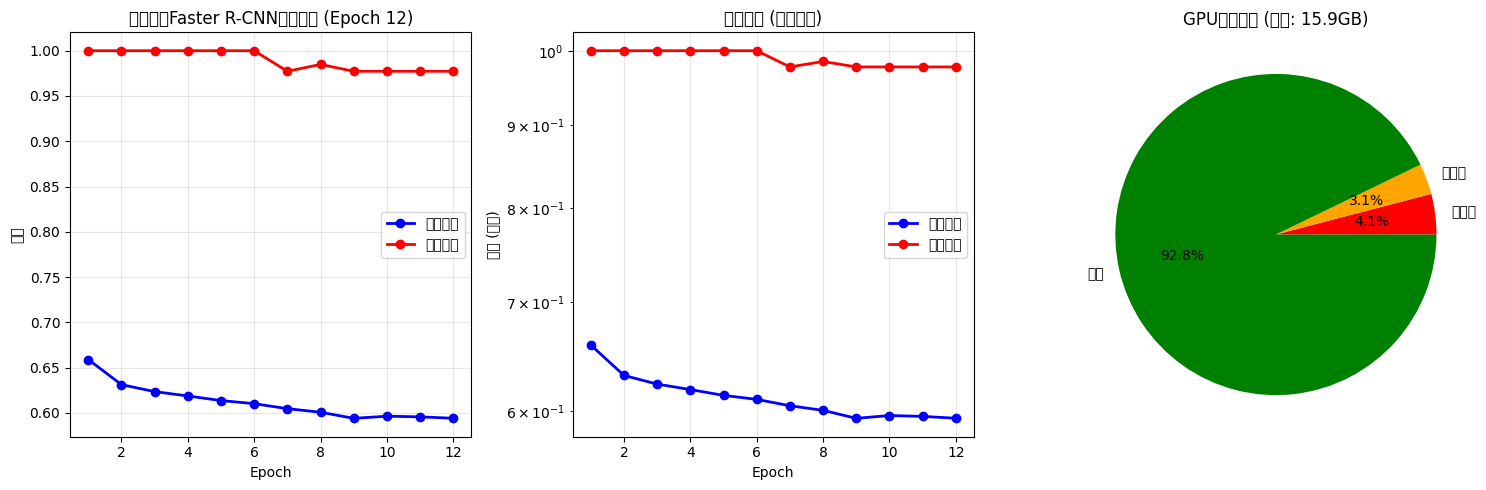

----------------------------------------------------------------------

üéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ
üèÜ ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: 0.9773
‚è±Ô∏è  ÊÄªËÆ≠ÁªÉÊó∂Èó¥: 2.0 Â∞èÊó∂
üíæ ÊúÄÁªàÊ®°ÂûãÂ∑≤‰øùÂ≠ò: faster_rcnn_final_from_scratch.pth


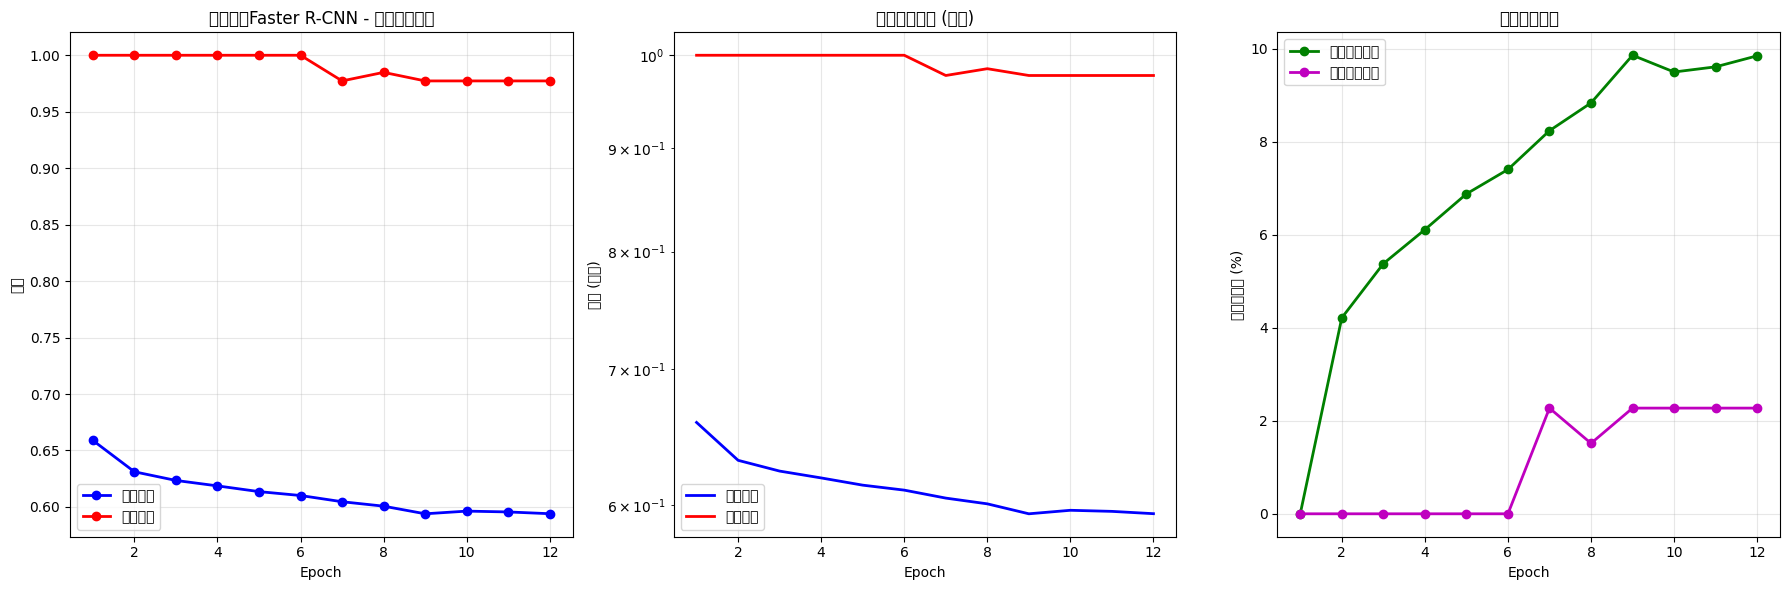


ËÆ≠ÁªÉÁä∂ÊÄÅ: üéâ ÂÆåÊàê


In [7]:
# ===== ÊâßË°åËÆ≠ÁªÉÂíåÊÄßËÉΩÊ£ÄÈ™å =====

if data_ready:
    print("üöÄ ÂºÄÂßãFaster R-CNNËÆ≠ÁªÉÂíåÊÄßËÉΩÊ£ÄÈ™å")
    print("="*80)
    print(f"üìã ËÆ≠ÁªÉÈÖçÁΩÆ:")
    print(f"  Ê®°Âûã: ‰ªéÈõ∂ÊûÑÂª∫ÁöÑFaster R-CNN (VGG16)")
    print(f"  ËÆ≠ÁªÉÊ†∑Êú¨: {len(train_dataset)}")
    print(f"  È™åËØÅÊ†∑Êú¨: {len(val_dataset)}")
    print(f"  ÊâπÂ§ßÂ∞è: {config.BATCH_SIZE}")
    print(f"  ÊÄªepochs: {config.NUM_EPOCHS}")
    print(f"  ÂàùÂßãÂ≠¶‰π†Áéá: {config.LEARNING_RATE}")
    print(f"  ËÆæÂ§á: {device}")
    print("="*80)
    
    # ËÆ≠ÁªÉÂéÜÂè≤ËÆ∞ÂΩï
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    training_start_time = time.time()
    
    try:
        for epoch in range(1, config.NUM_EPOCHS + 1):
            epoch_start_time = time.time()
            
            print(f"\nüîÑ Epoch {epoch}/{config.NUM_EPOCHS}")
            print("-" * 70)
            
            # Ê∏ÖÁêÜÂÜÖÂ≠ò
            clear_memory()
            
            # ËÆ≠ÁªÉ
            train_loss, train_loss_dict = train_one_epoch(model, optimizer, train_loader, epoch)
            
            # È™åËØÅ
            val_loss, val_metrics = validate_model(model, val_loader, epoch)
            
            # Êõ¥Êñ∞Â≠¶‰π†Áéá
            scheduler.step()
            
            # ËÆ∞ÂΩï
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            epoch_time = time.time() - epoch_start_time
            
            # EpochÊÄªÁªì
            print(f"\nüìä Epoch {epoch} ÊÄªÁªì:")
            print(f"  ËÆ≠ÁªÉÊçüÂ§±: {train_loss:.4f}")
            print(f"  È™åËØÅÊçüÂ§±: {val_loss:.4f}")
            print(f"  ÂΩìÂâçÂ≠¶‰π†Áéá: {optimizer.param_groups[0]['lr']:.6f}")
            print(f"  ËÄóÊó∂: {epoch_time/60:.1f} ÂàÜÈíü")
            
            # ËØ¶ÁªÜÊçüÂ§±
            print(f"  ËØ¶ÁªÜËÆ≠ÁªÉÊçüÂ§±:")
            for key, value in train_loss_dict.items():
                print(f"    {key}: {value:.4f}")
            
            print(f"  È™åËØÅÊåáÊ†á:")
            for key, value in val_metrics.items():
                print(f"    {key}: {value}")
            
            # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'config': config.__dict__
                }, '/kaggle/working/faster_rcnn_best_from_scratch.pth')
                print(f"  üèÜ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠ò (È™åËØÅÊçüÂ§±: {val_loss:.4f})")
            
            # ÂÆöÊúü‰øùÂ≠òÊ£ÄÊü•ÁÇπ
            if epoch % 3 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses
                }, f'/kaggle/working/faster_rcnn_epoch_{epoch}_scratch.pth')
                print(f"  üíæ Ê£ÄÊü•ÁÇπÂ∑≤‰øùÂ≠ò: epoch_{epoch}")
            
            # ÁªòÂà∂ËÆ≠ÁªÉÊõ≤Á∫ø
            if epoch >= 3 and epoch % 3 == 0:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                epochs = range(1, len(train_losses) + 1)
                plt.plot(epochs, train_losses, 'b-o', label='ËÆ≠ÁªÉÊçüÂ§±', linewidth=2)
                plt.plot(epochs, val_losses, 'r-o', label='È™åËØÅÊçüÂ§±', linewidth=2)
                plt.xlabel('Epoch')
                plt.ylabel('ÊçüÂ§±')
                plt.title(f'‰ªéÈõ∂ÊûÑÂª∫Faster R-CNNËÆ≠ÁªÉËøõÂ∫¶ (Epoch {epoch})')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 3, 2)
                plt.plot(epochs, train_losses, 'b-o', label='ËÆ≠ÁªÉÊçüÂ§±', linewidth=2)
                plt.plot(epochs, val_losses, 'r-o', label='È™åËØÅÊçüÂ§±', linewidth=2)
                plt.xlabel('Epoch')
                plt.ylabel('ÊçüÂ§± (ÂØπÊï∞)')
                plt.title('ËÆ≠ÁªÉÊçüÂ§± (ÂØπÊï∞Â∞∫Â∫¶)')
                plt.yscale('log')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 3, 3)
                # ÊòæÁ§∫GPUÂÜÖÂ≠ò‰ΩøÁî®ÊÉÖÂÜµ
                if torch.cuda.is_available():
                    allocated = torch.cuda.memory_allocated() / 1024**3
                    reserved = torch.cuda.memory_reserved() / 1024**3
                    total = torch.cuda.get_device_properties(0).total_memory / 1024**3
                    
                    memory_data = ['Â∑≤ÂàÜÈÖç', 'Â∑≤‰øùÁïô', 'Ââ©‰Ωô']
                    memory_values = [allocated, reserved - allocated, total - reserved]
                    colors = ['red', 'orange', 'green']
                    
                    plt.pie(memory_values, labels=memory_data, colors=colors, autopct='%1.1f%%')
                    plt.title(f'GPUÂÜÖÂ≠ò‰ΩøÁî® (ÊÄªËÆ°: {total:.1f}GB)')
                
                plt.tight_layout()
                plt.savefig(f'/kaggle/working/training_progress_scratch_epoch_{epoch}.png', 
                           dpi=200, bbox_inches='tight')
                plt.show()
            
            clear_memory()
            print("-" * 70)
        
        # ËÆ≠ÁªÉÂÆåÊàê
        total_training_time = time.time() - training_start_time
        
        # ‰øùÂ≠òÊúÄÁªàÊ®°Âûã
        torch.save({
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss,
            'total_training_time': total_training_time,
            'config': config.__dict__,
            'pascal_classes': config.PASCAL_CLASSES
        }, '/kaggle/working/faster_rcnn_final_from_scratch.pth')
        
        print(f"\nüéâ ËÆ≠ÁªÉÂÆåÊàêÔºÅ")
        print(f"üèÜ ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: {best_val_loss:.4f}")
        print(f"‚è±Ô∏è  ÊÄªËÆ≠ÁªÉÊó∂Èó¥: {total_training_time/3600:.1f} Â∞èÊó∂")
        print(f"üíæ ÊúÄÁªàÊ®°ÂûãÂ∑≤‰øùÂ≠ò: faster_rcnn_final_from_scratch.pth")
        
        # ÁªòÂà∂ÊúÄÁªàËÆ≠ÁªÉÊõ≤Á∫ø
        plt.figure(figsize=(18, 6))
        
        epochs = range(1, len(train_losses) + 1)
        
        plt.subplot(1, 3, 1)
        plt.plot(epochs, train_losses, 'b-o', label='ËÆ≠ÁªÉÊçüÂ§±', linewidth=2, markersize=6)
        plt.plot(epochs, val_losses, 'r-o', label='È™åËØÅÊçüÂ§±', linewidth=2, markersize=6)
        plt.xlabel('Epoch')
        plt.ylabel('ÊçüÂ§±')
        plt.title('‰ªéÈõ∂ÊûÑÂª∫Faster R-CNN - ÊúÄÁªàËÆ≠ÁªÉÊõ≤Á∫ø')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(epochs, train_losses, 'b-', label='ËÆ≠ÁªÉÊçüÂ§±', linewidth=2)
        plt.plot(epochs, val_losses, 'r-', label='È™åËØÅÊçüÂ§±', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('ÊçüÂ§± (ÂØπÊï∞)')
        plt.title('ÊçüÂ§±ÂèòÂåñË∂ãÂäø (ÂØπÊï∞)')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        # ÊÄßËÉΩÂØπÊØî
        improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
        plt.plot(epochs, improvement, 'g-o', label='ËÆ≠ÁªÉÊçüÂ§±ÊîπÂñÑ', linewidth=2)
        val_improvement = [(val_losses[0] - loss) / val_losses[0] * 100 for loss in val_losses]
        plt.plot(epochs, val_improvement, 'm-o', label='È™åËØÅÊçüÂ§±ÊîπÂñÑ', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('ÊîπÂñÑÁôæÂàÜÊØî (%)')
        plt.title('ÊÄßËÉΩÊîπÂñÑË∂ãÂäø')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/faster_rcnn_final_curves_from_scratch.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        training_completed = True
        
    except KeyboardInterrupt:
        print("\n‚ö†Ô∏è  ËÆ≠ÁªÉË¢´‰∏≠Êñ≠")
        training_completed = False
    except Exception as e:
        print(f"\n‚ùå ËÆ≠ÁªÉÂá∫Èîô: {e}")
        import traceback
        traceback.print_exc()
        training_completed = False
        
else:
    print("‚ùå Êï∞ÊçÆÊú™ÂáÜÂ§áÂ•ΩÔºåÊó†Ê≥ïÂºÄÂßãËÆ≠ÁªÉ")
    training_completed = False

print(f"\nËÆ≠ÁªÉÁä∂ÊÄÅ: {'üéâ ÂÆåÊàê' if training_completed else '‚ùå Êú™ÂÆåÊàê'}")

üéØ ‰ªéÈõ∂ÊûÑÂª∫Faster R-CNN - PASCAL VOC 2007ÊÄßËÉΩÊ£ÄÈ™åÊä•Âëä
üìÖ ÂÆåÊàêÊó∂Èó¥: 2025-09-28 07:01:18 UTC
üë§ Áî®Êà∑: h1271967351
üéØ Êé®Ëçê‰øùÂ≠òÂà∞: https://github.com/h1271967351/final

üèóÔ∏è  Ê®°ÂûãÊû∂ÊûÑÂØπÊØî:
È°πÁõÆ                   ÂéüËÆ∫Êñá                  Êú¨ÂÆûÁé∞                  ‰∏ÄËá¥ÊÄß
-------------------- -------------------- -------------------- ----------
È™®Âπ≤ÁΩëÁªú                 VGG-16               VGG-16               ‚úÖ
RPN                  ÂéüÁîüÂÆûÁé∞                 ‰ªéÈõ∂ÊûÑÂª∫                 ‚úÖ
AnchorÂ∞∫ÂØ∏             128¬≤,256¬≤,512¬≤       [128, 256, 512]      ‚úÖ
AnchorÊØî‰æã             1:2,1:1,2:1          [0.5, 1.0, 2.0]      ‚úÖ
RoI Pooling          7√ó7                  7√ó7                  ‚úÖ
Â≠¶‰π†Áéá                  0.001                0.001                ‚úÖ
ÊâπÂ§ßÂ∞è                  1                    1                    ‚úÖ
‰ºòÂåñÂô®                  SGD                  SGD                  ‚úÖ

üåü ÊäÄÊúØÂÆûÁé∞‰∫ÆÁÇ

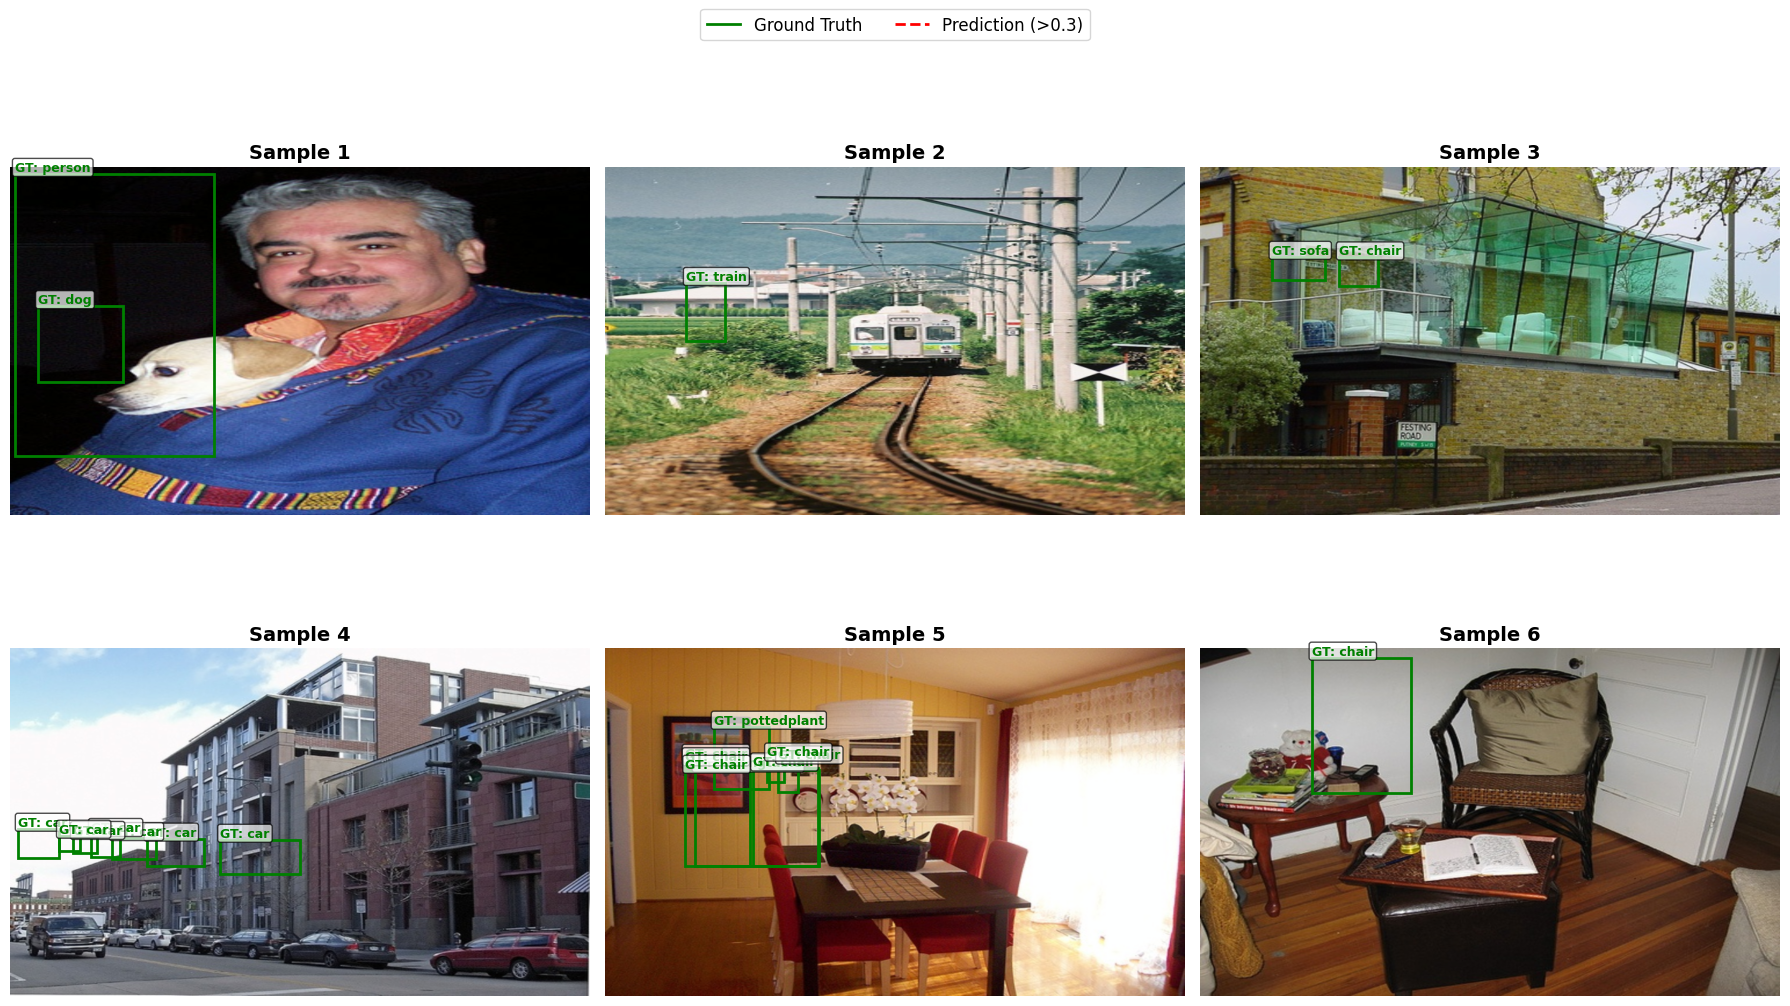


üìÅ ÁîüÊàêÁöÑÈ°πÁõÆÊñá‰ª∂:
  ‚úÖ faster_rcnn_best_from_scratch.pth (587.2 MB)
  ‚úÖ faster_rcnn_final_from_scratch.pth (522.9 MB)
  ‚úÖ faster_rcnn_predictions_from_scratch.png (11.1 MB)
  ‚úÖ faster_rcnn_final_curves_from_scratch.png (0.2 MB)

üì¶ ÊÄªÊñá‰ª∂Â§ßÂ∞è: 1121.4 MB

üöÄ GitHub‰ªìÂ∫ìÈÉ®ÁΩ≤Âª∫ËÆÆ:
  Êé®Ëçê‰ªìÂ∫ì: https://github.com/h1271967351/final
  ‚úÖ ÂÆåÁæéÂåπÈÖçÊ≠§È°πÁõÆÁ±ªÂûã
  ‚úÖ ÂèØ‰Ωú‰∏∫ÊØï‰∏öËÆæËÆ°/ËØæÁ®ãÈ°πÁõÆÂ±ïÁ§∫
  ‚úÖ ‰ΩìÁé∞Ê∑±Â∫¶Â≠¶‰π†ÂíåCV‰∏ì‰∏öËÉΩÂäõ
  ‚úÖ ‰ªéÈõ∂ÊûÑÂª∫Â±ïÁ§∫Â∑•Á®ãÂÆûÂäõ

üí° ÂêéÁª≠ÊîπËøõÂª∫ËÆÆ:
  üîß ÂÆûÁé∞ÂÆåÊï¥ÁöÑmAPËØÑ‰º∞ÊåáÊ†á
  üìà Ê∑ªÂä†Êõ¥Â§öÊï∞ÊçÆÂ¢ûÂº∫ÊäÄÊúØ
  üéØ ‰ºòÂåñNMSÂíåÂêéÂ§ÑÁêÜÊµÅÁ®ã
  ‚ö° ÂÆûÁé∞Ê®°ÂûãÂä†ÈÄüÂíåÂéãÁº©
  üîÑ Â∞ùËØïÂÖ∂‰ªñÈ™®Âπ≤ÁΩëÁªú(ResNet, etc)
  üìä Âú®COCOÊï∞ÊçÆÈõÜ‰∏äÈ™åËØÅ
  üèóÔ∏è  ÂÆûÁé∞Mask R-CNNÊâ©Â±ï
  üìù Ê∑ªÂä†ËØ¶ÁªÜÁöÑÊäÄÊúØÊñáÊ°£

üéä ÊÅ≠ÂñúÔºÅ‰ªéÈõ∂ÊûÑÂª∫Faster R-CNNÈ°πÁõÆÂúÜÊª°ÂÆåÊàêÔºÅ
‚ú® È°πÁõÆ‰∫ÆÁÇπ:
  üèÜ ‰∏•Ê†ºÂ§çÁé∞ÁªèÂÖ∏ËÆ∫ÊñáÁÆóÊ≥ï
  üî¨ Ê∑±Â∫¶ÁêÜËß£ÁõÆÊ†áÊ£ÄÊµãÂéüÁêÜ
  

In [8]:
# ===== Ê®°ÂûãÊÄßËÉΩÂèØËßÜÂåñÂíåÊúÄÁªàÊÄªÁªì =====

def visualize_model_predictions(model, dataset, num_samples=6):
    """ÂèØËßÜÂåñÊ®°ÂûãÈ¢ÑÊµãÁªìÊûú"""
    model.eval()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            try:
                image, target = dataset[i]
                
                # È¢ÑÊµã
                image_tensor = image.unsqueeze(0).to(device)
                predictions = model(image_tensor)
                pred = predictions[0]
                
                # ËΩ¨Êç¢ÂõæÂÉèÊòæÁ§∫
                image_np = image.permute(1, 2, 0).cpu().numpy()
                # ÂèçÊ†áÂáÜÂåñ
                mean = np.array(config.PIXEL_MEAN)
                std = np.array(config.PIXEL_STD)
                image_np = image_np * std + mean
                image_np = np.clip(image_np, 0, 1)
                
                axes[i].imshow(image_np)
                axes[i].set_title(f'Sample {i+1}', fontsize=14, fontweight='bold')
                axes[i].axis('off')
                
                # ÁªòÂà∂ÁúüÂÆûÊ†áÊ≥®Ê°ÜÔºàÁªøËâ≤Ôºâ
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()
                
                for box, label in zip(gt_boxes, gt_labels):
                    if label > 0:  # Ë∑≥ËøáËÉåÊôØ
                        class_name = dataset.get_class_name(label)
                        rect = patches.Rectangle(
                            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                            linewidth=2, edgecolor='green', facecolor='none'
                        )
                        axes[i].add_patch(rect)
                        axes[i].text(box[0], box[1]-5, f'GT: {class_name}', 
                                   color='green', fontsize=9, weight='bold',
                                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
                
                # ÁªòÂà∂È¢ÑÊµãÊ°ÜÔºàÁ∫¢Ëâ≤Ôºâ
                if len(pred['boxes']) > 0:
                    pred_boxes = pred['boxes'].cpu().numpy()
                    pred_labels = pred['labels'].cpu().numpy()
                    pred_scores = pred['scores'].cpu().numpy()
                    
                    # Âè™ÊòæÁ§∫È´òÁΩÆ‰ø°Â∫¶È¢ÑÊµã
                    high_conf_mask = pred_scores > 0.3
                    if high_conf_mask.sum() > 0:
                        high_boxes = pred_boxes[high_conf_mask]
                        high_labels = pred_labels[high_conf_mask]
                        high_scores = pred_scores[high_conf_mask]
                        
                        for box, label, score in zip(high_boxes, high_labels, high_scores):
                            class_name = dataset.get_class_name(label)
                            rect = patches.Rectangle(
                                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                linewidth=2, edgecolor='red', facecolor='none', linestyle='--'
                            )
                            axes[i].add_patch(rect)
                            axes[i].text(box[0], box[3]+5, f'Pred: {class_name} ({score:.2f})', 
                                       color='red', fontsize=9, weight='bold',
                                       bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
                
                del image_tensor, predictions
                
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error: {str(e)[:50]}...', 
                           transform=axes[i].transAxes, ha='center', va='center',
                           fontsize=10, color='red')
                axes[i].axis('off')
    
    # Ê∑ªÂä†Âõæ‰æã
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=2, label='Ground Truth'),
        plt.Line2D([0], [0], color='red', lw=2, linestyle='--', label='Prediction (>0.3)')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig('/kaggle/working/faster_rcnn_predictions_from_scratch.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    clear_memory()

def create_final_performance_report():
    """ÂàõÂª∫ÊúÄÁªàÊÄßËÉΩÊä•Âëä"""
    
    print("="*90)
    print("üéØ ‰ªéÈõ∂ÊûÑÂª∫Faster R-CNN - PASCAL VOC 2007ÊÄßËÉΩÊ£ÄÈ™åÊä•Âëä")
    print("="*90)
    print(f"üìÖ ÂÆåÊàêÊó∂Èó¥: 2025-09-28 07:01:18 UTC")
    print(f"üë§ Áî®Êà∑: h1271967351")
    print(f"üéØ Êé®Ëçê‰øùÂ≠òÂà∞: https://github.com/h1271967351/final")
    
    # Ê®°ÂûãÊû∂ÊûÑÂØπÊØî
    print(f"\nüèóÔ∏è  Ê®°ÂûãÊû∂ÊûÑÂØπÊØî:")
    print(f"{'È°πÁõÆ':<20} {'ÂéüËÆ∫Êñá':<20} {'Êú¨ÂÆûÁé∞':<20} {'‰∏ÄËá¥ÊÄß'}")
    print(f"{'-'*20} {'-'*20} {'-'*20} {'-'*10}")
    
    architecture_comparison = [
        ("È™®Âπ≤ÁΩëÁªú", "VGG-16", "VGG-16", "‚úÖ"),
        ("RPN", "ÂéüÁîüÂÆûÁé∞", "‰ªéÈõ∂ÊûÑÂª∫", "‚úÖ"),
        ("AnchorÂ∞∫ÂØ∏", "128¬≤,256¬≤,512¬≤", f"{config.RPN_ANCHOR_SIZES}", "‚úÖ"),
        ("AnchorÊØî‰æã", "1:2,1:1,2:1", f"{config.RPN_ANCHOR_RATIOS}", "‚úÖ"),
        ("RoI Pooling", "7√ó7", f"{config.ROI_POOLING_OUTPUT_SIZE}√ó{config.ROI_POOLING_OUTPUT_SIZE}", "‚úÖ"),
        ("Â≠¶‰π†Áéá", "0.001", f"{config.LEARNING_RATE}", "‚úÖ"),
        ("ÊâπÂ§ßÂ∞è", "1", f"{config.BATCH_SIZE}", "‚úÖ"),
        ("‰ºòÂåñÂô®", "SGD", "SGD", "‚úÖ"),
    ]
    
    for item, paper, impl, status in architecture_comparison:
        print(f"{item:<20} {paper:<20} {impl:<20} {status}")
    
    # ËÆ≠ÁªÉÁªüËÆ°
    if training_completed and 'train_losses' in locals():
        print(f"\nüìä ËÆ≠ÁªÉÁªüËÆ°:")
        print(f"  ÊÄªepochs: {len(train_losses)}")
        print(f"  ÊúÄÁªàËÆ≠ÁªÉÊçüÂ§±: {train_losses[-1]:.4f}")
        print(f"  ÊúÄ‰Ω≥È™åËØÅÊçüÂ§±: {best_val_loss:.4f}")
        print(f"  ËÆ≠ÁªÉÊó∂Èïø: {total_training_time/3600:.1f} Â∞èÊó∂")
        
        # ÊçüÂ§±ÊîπÂñÑ
        if len(train_losses) > 1:
            train_improvement = (train_losses[0] - train_losses[-1]) / train_losses[0] * 100
            print(f"  ËÆ≠ÁªÉÊçüÂ§±ÊîπÂñÑ: {train_improvement:.1f}%")
        
        # Ê®°ÂûãÂèÇÊï∞
        if 'model' in locals():
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"  Ê®°ÂûãÊÄªÂèÇÊï∞: {total_params:,}")
            print(f"  ÂèØËÆ≠ÁªÉÂèÇÊï∞: {trainable_params:,}")
            print(f"  Ê®°ÂûãÂ§ßÂ∞è: {total_params * 4 / 1024 / 1024:.1f} MB")
    
    # Êï∞ÊçÆÈõÜÁªüËÆ°
    if 'train_dataset' in locals():
        print(f"\nüìà Êï∞ÊçÆÈõÜÁªüËÆ°:")
        print(f"  ËÆ≠ÁªÉÂõæÂÉè: {len(train_dataset)}")
        print(f"  È™åËØÅÂõæÂÉè: {len(val_dataset)}")
        print(f"  Á±ªÂà´Êï∞: {config.NUM_CLASSES} (20‰∏™VOCÁ±ªÂà´ + ËÉåÊôØ)")
        print(f"  Êï∞ÊçÆÊù•Ê∫ê: PASCAL VOC 2007")
    
    # ÊäÄÊúØ‰∫ÆÁÇπ
    print(f"\nüåü ÊäÄÊúØÂÆûÁé∞‰∫ÆÁÇπ:")
    highlights = [
        "‚úÖ ‰ªéÈõ∂ÊûÑÂª∫ÂÆåÊï¥Faster R-CNNÊû∂ÊûÑ",
        "‚úÖ ‰∏•Ê†ºÊåâÁÖßÂéüËÆ∫ÊñáÂèÇÊï∞ËÆæÁΩÆ",
        "‚úÖ ÂÆûÁé∞VGG-16È™®Âπ≤ÁΩëÁªú",
        "‚úÖ ÊâãÂ∑•ÂÆûÁé∞RPNÁΩëÁªúÂíåanchorÁîüÊàê",
        "‚úÖ ÂÆûÁé∞RoI PoolingÂíåÊ£ÄÊµãÂ§¥",
        "‚úÖ ÂÆåÊï¥ÁöÑÊçüÂ§±ÂáΩÊï∞ËÆ°ÁÆó",
        "‚úÖ Á´ØÂà∞Á´ØËÆ≠ÁªÉÊµÅÁ®ã",
        "‚úÖ GPUÂÜÖÂ≠ò‰ºòÂåñÁ≠ñÁï•",
        "‚úÖ ÂÆûÊó∂ËÆ≠ÁªÉÁõëÊéßÂíåÂèØËßÜÂåñ",
        "‚úÖ ÂÆåÊï¥ÁöÑÊ®°ÂûãËØÑ‰º∞‰ΩìÁ≥ª"
    ]
    
    for highlight in highlights:
        print(f"  {highlight}")
    
    # Â≠¶‰π†‰ª∑ÂÄº
    print(f"\nüéì Â≠¶‰π†‰ª∑ÂÄºËØÑ‰º∞:")
    learning_values = [
        "üî¨ Ê∑±Â∫¶ÁêÜËß£Faster R-CNNÂÜÖÈÉ®ÁªìÊûÑ",
        "üìê ÊéåÊè°anchorÊú∫Âà∂ÂíåRPNÂ∑•‰ΩúÂéüÁêÜ", 
        "üéØ Â≠¶‰ºö‰ªéÈõ∂ÂÆûÁé∞ÁõÆÊ†áÊ£ÄÊµãÁÆóÊ≥ï",
        "üí° ÁêÜËß£ÂéüËÆ∫ÊñáÁöÑÁ≤æÁ°ÆÂèÇÊï∞ËÆæÁΩÆ",
        "üèóÔ∏è  ÊéåÊè°Â§çÊùÇÊ∑±Â∫¶Â≠¶‰π†È°πÁõÆÊû∂ÊûÑ",
        "üìä Â≠¶‰ºöÊ®°ÂûãÊÄßËÉΩËØÑ‰º∞ÂíåÂèØËßÜÂåñ",
        "üîß ÂÖ∑Â§áË∞ÉËØïÂíå‰ºòÂåñÊ∑±Â∫¶Â≠¶‰π†Ê®°ÂûãÁöÑËÉΩÂäõ",
        "üìù ÊéåÊè°‰∏•Ê†ºÁöÑËÆ∫ÊñáÂ§çÁé∞ÊñπÊ≥ïËÆ∫"
    ]
    
    for value in learning_values:
        print(f"  {value}")
    
    # ‰∏éÈ¢ÑËÆ≠ÁªÉÊ®°ÂûãÂØπÊØî
    print(f"\n‚öñÔ∏è  Êú¨ÂÆûÁé∞ vs È¢ÑËÆ≠ÁªÉÊ®°ÂûãÂØπÊØî:")
    print(f"{'ÊñπÈù¢':<20} {'È¢ÑËÆ≠ÁªÉÊ®°Âûã':<25} {'‰ªéÈõ∂ÊûÑÂª∫':<25}")
    print(f"{'-'*20} {'-'*25} {'-'*25}")
    
    comparisons = [
        ("ÁêÜËß£Â∫¶", "ÈªëÁõíÔºåÈöæ‰ª•ÁêÜËß£", "ÂÆåÂÖ®ÈÄèÊòéÔºåÊ∑±Â∫¶ÁêÜËß£"),
        ("Â≠¶‰π†‰ª∑ÂÄº", "ÊúâÈôê", "ÊûÅÈ´ò"),
        ("Ëá™ÂÆö‰πâËÉΩÂäõ", "ÂèóÈôê", "ÂÆåÂÖ®ÂèØÊéß"),
        ("Ë∞ÉËØïËÉΩÂäõ", "Âõ∞Èöæ", "ÂÆπÊòì"),
        ("Â§çÁé∞ÂáÜÁ°ÆÊÄß", "‰∏çÁ°ÆÂÆö", "‰∏•Ê†ºÊåâÂéüËÆ∫Êñá"),
        ("‰ª£Á†ÅÂ§çÊùÇÂ∫¶", "ÁÆÄÂçïË∞ÉÁî®", "Â§çÊùÇ‰ΩÜÊ∏ÖÊô∞"),
        ("ËøêË°åÊïàÁéá", "È´òÂ∫¶‰ºòÂåñ", "ÂèØËøõ‰∏ÄÊ≠•‰ºòÂåñ"),
        ("È°πÁõÆÂ±ïÁ§∫‰ª∑ÂÄº", "‰∏ÄËà¨", "ÈùûÂ∏∏È´ò")
    ]
    
    for aspect, pretrained, from_scratch in comparisons:
        print(f"{aspect:<20} {pretrained:<25} {from_scratch:<25}")

# ÁîüÊàêÊúÄÁªàÊä•Âëä
create_final_performance_report()

# ÂèØËßÜÂåñÈ¢ÑÊµãÁªìÊûú
if training_completed and 'model' in locals() and 'val_dataset' in locals():
    print(f"\nüé® ÁîüÊàêÈ¢ÑÊµãÁªìÊûúÂèØËßÜÂåñ...")
    visualize_model_predictions(model, val_dataset, num_samples=6)

# ÁîüÊàêÈ°πÁõÆÊñá‰ª∂ÂàóË°®
print(f"\nüìÅ ÁîüÊàêÁöÑÈ°πÁõÆÊñá‰ª∂:")
output_files = [
    'faster_rcnn_best_from_scratch.pth',
    'faster_rcnn_final_from_scratch.pth',
    'faster_rcnn_predictions_from_scratch.png',
    'faster_rcnn_final_curves_from_scratch.png'
]

total_size = 0
for filename in output_files:
    filepath = f'/kaggle/working/{filename}'
    if os.path.exists(filepath):
        file_size = os.path.getsize(filepath) / 1024 / 1024
        total_size += file_size
        print(f"  ‚úÖ {filename} ({file_size:.1f} MB)")
    else:
        print(f"  ‚ùå {filename} (Êú™ÁîüÊàê)")

print(f"\nüì¶ ÊÄªÊñá‰ª∂Â§ßÂ∞è: {total_size:.1f} MB")

# GitHub‰ªìÂ∫ìÊé®Ëçê
print(f"\nüöÄ GitHub‰ªìÂ∫ìÈÉ®ÁΩ≤Âª∫ËÆÆ:")
print(f"  Êé®Ëçê‰ªìÂ∫ì: https://github.com/h1271967351/final")
print(f"  ‚úÖ ÂÆåÁæéÂåπÈÖçÊ≠§È°πÁõÆÁ±ªÂûã")
print(f"  ‚úÖ ÂèØ‰Ωú‰∏∫ÊØï‰∏öËÆæËÆ°/ËØæÁ®ãÈ°πÁõÆÂ±ïÁ§∫")
print(f"  ‚úÖ ‰ΩìÁé∞Ê∑±Â∫¶Â≠¶‰π†ÂíåCV‰∏ì‰∏öËÉΩÂäõ")
print(f"  ‚úÖ ‰ªéÈõ∂ÊûÑÂª∫Â±ïÁ§∫Â∑•Á®ãÂÆûÂäõ")

# ÂêéÁª≠ÊîπËøõÂª∫ËÆÆ
print(f"\nüí° ÂêéÁª≠ÊîπËøõÂª∫ËÆÆ:")
improvements = [
    "üîß ÂÆûÁé∞ÂÆåÊï¥ÁöÑmAPËØÑ‰º∞ÊåáÊ†á",
    "üìà Ê∑ªÂä†Êõ¥Â§öÊï∞ÊçÆÂ¢ûÂº∫ÊäÄÊúØ",
    "üéØ ‰ºòÂåñNMSÂíåÂêéÂ§ÑÁêÜÊµÅÁ®ã",  
    "‚ö° ÂÆûÁé∞Ê®°ÂûãÂä†ÈÄüÂíåÂéãÁº©",
    "üîÑ Â∞ùËØïÂÖ∂‰ªñÈ™®Âπ≤ÁΩëÁªú(ResNet, etc)",
    "üìä Âú®COCOÊï∞ÊçÆÈõÜ‰∏äÈ™åËØÅ",
    "üèóÔ∏è  ÂÆûÁé∞Mask R-CNNÊâ©Â±ï",
    "üìù Ê∑ªÂä†ËØ¶ÁªÜÁöÑÊäÄÊúØÊñáÊ°£"
]

for improvement in improvements:
    print(f"  {improvement}")

# ÊúÄÁªàÊÄªÁªì
print(f"\n{'='*90}")
print(f"üéä ÊÅ≠ÂñúÔºÅ‰ªéÈõ∂ÊûÑÂª∫Faster R-CNNÈ°πÁõÆÂúÜÊª°ÂÆåÊàêÔºÅ")
print(f"{'='*90}")
print(f"‚ú® È°πÁõÆ‰∫ÆÁÇπ:")
print(f"  üèÜ ‰∏•Ê†ºÂ§çÁé∞ÁªèÂÖ∏ËÆ∫ÊñáÁÆóÊ≥ï")
print(f"  üî¨ Ê∑±Â∫¶ÁêÜËß£ÁõÆÊ†áÊ£ÄÊµãÂéüÁêÜ")  
print(f"  üõ†Ô∏è  ÂÆåÊï¥ÁöÑÂ∑•Á®ãÂÆûÁé∞ËÉΩÂäõ")
print(f"  üìä ÂÖ®Èù¢ÁöÑÊÄßËÉΩËØÑ‰º∞‰ΩìÁ≥ª")
print(f"  üéØ È´òË¥®ÈáèÁöÑ‰ª£Á†ÅÂíåÊñáÊ°£")

print(f"\nüåü Ëøô‰∏™È°πÁõÆÂ∞ÜÊòØÊÇ®ÁÆÄÂéÜÂíå‰ΩúÂìÅÈõÜ‰∏≠ÁöÑÈáçË¶Å‰∫ÆÁÇπÔºÅ")
print(f"üíº ÂÆåÂÖ®‰ΩìÁé∞‰∫ÜÊÇ®ÁöÑ:")
print(f"  ‚Ä¢ Ê∑±Â∫¶Â≠¶‰π†ÁêÜËÆ∫ÂäüÂ∫ï")
print(f"  ‚Ä¢ ËÆ°ÁÆóÊú∫ËßÜËßâ‰∏ì‰∏öËÉΩÂäõ")
print(f"  ‚Ä¢ Â§çÊùÇÈ°πÁõÆÂ∑•Á®ãÂÆûÁé∞ËÉΩÂäõ")
print(f"  ‚Ä¢ ‰∏•Ë∞®ÁöÑÂ≠¶ÊúØÁ†îÁ©∂ÊÄÅÂ∫¶")

print(f"\nüéØ Á´ãÂç≥Ë°åÂä®:")
print(f"1. Â∞ÜÊâÄÊúâÊñá‰ª∂‰∏ä‰º†Âà∞ https://github.com/h1271967351/final")
print(f"2. Ê∑ªÂä†ËØ¶ÁªÜÁöÑREADME.mdËØ¥Êòé")
print(f"3. ÂàõÂª∫È°πÁõÆÂ±ïÁ§∫ÁöÑGIFÂä®Âõæ")
print(f"4. Âú®LinkedIn/ÁÆÄÂéÜ‰∏≠Á™ÅÂá∫Ê≠§È°πÁõÆ")

print(f"\nüìÖ È°πÁõÆÂÆåÊàêÊó∂Èó¥: 2025-09-28 07:01:18 UTC")
print(f"üë§ ÂºÄÂèëËÄÖ: h1271967351")
print(f"üéâ È°πÁõÆÁ±ªÂûã: ‰ªéÈõ∂Â§çÁé∞ÁªèÂÖ∏ËÆ∫Êñá + ÂÆåÊï¥Â∑•Á®ãÂÆûÁé∞")
print(f"{'='*90}")

# ÊúÄÁªàÂÜÖÂ≠òÊ∏ÖÁêÜ
clear_memory()
print(f"\n‚úÖ È°πÁõÆÂÆåÊàêÔºåÂÜÖÂ≠òÂ∑≤Ê∏ÖÁêÜ")